In [91]:
import pandas as pd
from featurewiz import featurewiz
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import yfinance as yf
from xgboost import plot_importance
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate
import datetime
import dask as da
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [92]:
basic_data = pd.read_csv("..\\7. Data Preparation\\Basic_information_cleaned5.csv", index_col=0)
# res_df = res_df.sort_values(by="Market Cap", ascending=False).head(round(res_df.shape[0] * 0.7))

In [93]:
ordinal = OrdinalEncoder()

basic_data["Sector"] = ordinal.fit_transform(basic_data["Sector"].values.reshape(-1, 1))
basic_data["Industry"] = ordinal.fit_transform(basic_data["Industry"].values.reshape(-1, 1))

# Functions

In [94]:
def get_fcf_val(current_earnings,growth_1,growth_2, discount_rate, exit_multiple):
    year1 = (current_earnings * (1 + growth_1))
    year2 = (year1 * (1 + growth_1))
    year3 = (year2 * (1 + growth_1))
    year4 = (year3 * (1 + growth_1))
    year5 = (year4 * (1 + growth_1))
    year6 = (year5 * (1 + growth_2))
    year7 = (year6 * (1 + growth_2))
    year8 = (year7 * (1 + growth_2))
    year9 = (year8 * (1 + growth_2))
    year10 = (year9 * (1 + growth_2))

    discounted_year1 = year1 / (1 + discount_rate)
    discounted_year2 = year2 / (1 + discount_rate)**2
    discounted_year3 = year3 / (1 + discount_rate)**3
    discounted_year4 = year4 / (1 + discount_rate)**4
    discounted_year5 = year5 / (1 + discount_rate)**5
    discounted_year6 = year6 / (1 + discount_rate)**6
    discounted_year7 = year7 / (1 + discount_rate)**7
    discounted_year8 = year8 / (1 + discount_rate)**8
    discounted_year9 = year9 / (1 + discount_rate)**9
    discounted_year10 = year10 / (1 + discount_rate)**10

    discounted_values = [discounted_year1, discounted_year2, discounted_year3, discounted_year4, discounted_year5, discounted_year6, discounted_year7, discounted_year8, discounted_year9, discounted_year10]

    exit_value = (year10 * exit_multiple) / (1 + discount_rate)**10

    dcf = pd.DataFrame({"Discounted Value": discounted_values}, index=["Year 1", "Year 2", "Year 3", "Year 4", "Year 5", "Year 6", "Year 7", "Year 8", "Year 9", "Year 10"])
    dcf["Cumulative Value"] = dcf["Discounted Value"].cumsum()

    present_value = dcf.at["Year 9","Cumulative Value"] + exit_value
    return present_value.round(2)

In [152]:
def calculateGrowthMetrics(df,selected_columns):
    
    for column in selected_columns:
        df[column+" growth year over year"] = df[column] / df[column].shift(1) - 1
        df[column+" growth 3 year average"] = (df[column+" growth year over year"] + df[column+" growth year over year"].shift(1) + df[column+" growth year over year"].shift(2))  / 3
        df[column+" growth 5 year average"] = (df[column+" growth year over year"] + df[column+" growth year over year"].shift(1) + df[column+" growth year over year"].shift(2) + df[column+" growth year over year"].shift(3) + df[column+" growth year over year"].shift(4))  / 5
        df[column+" growth 10 year average"] = (df[column+" growth year over year"] + df[column+" growth year over year"].shift(1) + df[column+" growth year over year"].shift(2) + df[column+" growth year over year"].shift(3) + df[column+" growth year over year"].shift(4) + df[column+" growth year over year"].shift(5) + df[column+" growth year over year"].shift(6) + df[column+" growth year over year"].shift(7) + df[column+" growth year over year"].shift(8) + df[column+" growth year over year"].shift(9) + df[column+" growth year over year"].shift(10))  / 10

    # Quitamos infinitos
    df = df.replace([np.inf, -np.inf], np.nan)

In [153]:
def calculate_valuation_metrics(ticker):
    fundamental_data = pd.read_csv("..\\7. Data Preparation\\FinalFundamentalsWithGrowth\\"+ticker+".csv", index_col=0)

    try:
        fundamental_data.drop("Forex Rate", axis=1, inplace=True)
    except:
        pass

    # Por error algunos datos tenían más columnas de las que tocaban, las ignoramos
    if fundamental_data.shape[1] > 985:
        fundamental_data = fundamental_data.iloc[:,:985]

    selected_columns = ["PER Last Year", "PER_3", "PER_5", "PER_10", "Intrinsic Value", "Intrinsic Value 3", "Intrinsic Value 5","Intrinsic Value 10","Intrinsic Value FCF",
                        "Intrinsic Value FCF SAFE","Intrinsic Value FCF RISKY","Price Moving Average 2 years", "Price Moving Average 3 years","Price Moving Average 4 years",
                        "Price Moving Average 5 years","Price Moving Average 6 years","Price Moving Average 7 years","Price Moving Average 8 years","Price Moving Average 9 years",
                        "Price Moving Average 10 years","Price to Book", "Grahams Number", "Grahams Number 3", "Grahams Number 5", "Grahams Number 10", "IV Grahams Number",
                        "IV Grahams Number 3", "IV Grahams Number 5", "IV Grahams Number 10", "PEG","Last Year Price", "Last 3 Years Price Mean", "Last 5 Years Price Mean",
                        "Last 10 Years Price Mean", "Price to Book 3", "Price to Book 5", "Price to Book 10", "IV Price to Book", "IV Price to Book 3", "IV Price to Book 5",
                        "IV Price to Book 10", "PEG 3", "PEG 5", "PEG 10", "IV PEG", "IV PEG 3", "IV PEG 5", "IV PEG 10", "Price to Free Cash Flow","Price to Free Cash Flow 3",
                        "Price to Free Cash Flow 5", "Price to Free Cash Flow 10", "IV Price to Free Cash Flow", "IV Price to Free Cash Flow 3", "IV Price to Free Cash Flow 5",
                        "IV Price to Free Cash Flow 10", "PEG 3", "PEG 5", "PEG 10", "IV PEG", "IV PEG 3", "IV PEG 5", "IV PEG 10", ]
    
    # init selectedcolumns as nan
    for column in selected_columns:
        fundamental_data[column] = np.nan
    

    # Precio histórico
    fundamental_data["Last Year Price"] = fundamental_data["Close"].shift(1)
    fundamental_data["Last 3 Years Price Mean"] = fundamental_data["Close"].rolling(3).mean()
    fundamental_data["Last 5 Years Price Mean"] = fundamental_data["Close"].rolling(5).mean()
    fundamental_data["Last 10 Years Price Mean"] = fundamental_data["Close"].rolling(10).mean()

    # calculamos el per histórico
    fundamental_data["PER Last Year"] = fundamental_data["Close"].shift(1) / fundamental_data["EPS"].shift(1)
    fundamental_data["PER_3"] = fundamental_data["PER Last Year"].rolling(3).mean()
    fundamental_data["PER_5"] = fundamental_data["PER Last Year"].rolling(5).mean()
    fundamental_data["PER_10"] = fundamental_data["PER Last Year"].rolling(10).mean()

    fundamental_data["Intrinsic Value"] = fundamental_data["EPS"] * fundamental_data["PER Last Year"]
    fundamental_data["Intrinsic Value 3"] = fundamental_data["EPS"] * fundamental_data["PER_3"]
    fundamental_data["Intrinsic Value 5"] = fundamental_data["EPS"] * fundamental_data["PER_5"]
    fundamental_data["Intrinsic Value 10"] = fundamental_data["EPS"] * fundamental_data["PER_10"]

    # calculamos el price to book value histórico
    fundamental_data["Price to Book"] = fundamental_data["Close"].shift(1) / fundamental_data["Book value per share"]
    fundamental_data["Price to Book 3"] = fundamental_data["Price to Book"].rolling(3).mean()
    fundamental_data["Price to Book 5"] = fundamental_data["Price to Book"].rolling(5).mean()
    fundamental_data["Price to Book 10"] = fundamental_data["Price to Book"].rolling(10).mean()

    fundamental_data["IV Price to Book"] = fundamental_data["Book value per share"] * fundamental_data["Price to Book"]
    fundamental_data["IV Price to Book 3"] = fundamental_data["Book value per share"] * fundamental_data["Price to Book 3"]
    fundamental_data["IV Price to Book 5"] = fundamental_data["Book value per share"] * fundamental_data["Price to Book 5"]
    fundamental_data["IV Price to Book 10"] = fundamental_data["Book value per share"] * fundamental_data["Price to Book 10"]


    # calculamos el price to free cash flow histórico
    fundamental_data["Price to Free Cash Flow"] = fundamental_data["Close"].shift(1) / fundamental_data["FCF per share"]
    fundamental_data["Price to Free Cash Flow 3"] = fundamental_data["Price to Free Cash Flow"].rolling(3).mean()
    fundamental_data["Price to Free Cash Flow 5"] = fundamental_data["Price to Free Cash Flow"].rolling(5).mean()
    fundamental_data["Price to Free Cash Flow 10"] = fundamental_data["Price to Free Cash Flow"].rolling(10).mean()
    
    fundamental_data["IV Price to Free Cash Flow"] = fundamental_data["FCF per share"] * fundamental_data["Price to Free Cash Flow"]
    fundamental_data["IV Price to Free Cash Flow 3"] = fundamental_data["FCF per share"] * fundamental_data["Price to Free Cash Flow 3"]
    fundamental_data["IV Price to Free Cash Flow 5"] = fundamental_data["FCF per share"] * fundamental_data["Price to Free Cash Flow 5"]
    fundamental_data["IV Price to Free Cash Flow 10"] = fundamental_data["FCF per share"] * fundamental_data["Price to Free Cash Flow 10"]
    
    # calculamos el graham number
    fundamental_data["Grahams Number"] = np.sqrt(22.5*fundamental_data["EPS"] * fundamental_data["Common Tangible Book Value"])
    fundamental_data["Grahams Number 3"] = fundamental_data["Grahams Number"].rolling(3).mean()
    fundamental_data["Grahams Number 5"] = fundamental_data["Grahams Number"].rolling(5).mean()
    fundamental_data["Grahams Number 10"] = fundamental_data["Grahams Number"].rolling(10).mean()

    fundamental_data["Price to Grahams Number"] = fundamental_data["Close"].shift(1) / fundamental_data["Grahams Number"]
    fundamental_data["Price to Grahams Number 3"] = fundamental_data["Price to Grahams Number"].rolling(3).mean()
    fundamental_data["Price to Grahams Number 5"] = fundamental_data["Price to Grahams Number"].rolling(5).mean()
    fundamental_data["Price to Grahams Number 10"] = fundamental_data["Price to Grahams Number"].rolling(10).mean()

    fundamental_data["IV Grahams Number"] = fundamental_data["Grahams Number"] * fundamental_data["Price to Grahams Number"]
    fundamental_data["IV Grahams Number 3"] = fundamental_data["Grahams Number"] * fundamental_data["Price to Grahams Number 3"]
    fundamental_data["IV Grahams Number 5"] = fundamental_data["Grahams Number"] * fundamental_data["Price to Grahams Number 5"]
    fundamental_data["IV Grahams Number 10"] = fundamental_data["Grahams Number"] * fundamental_data["Price to Grahams Number 10"]

    # calculamos el peg
    fundamental_data["PEG"] = fundamental_data["PER Last Year"] / fundamental_data["EPS Diluted growth 3 year average"]
    fundamental_data["PEG 3"] = fundamental_data["PEG"].rolling(3).mean()
    fundamental_data["PEG 5"] = fundamental_data["PEG"].rolling(5).mean()
    fundamental_data["PEG 10"] = fundamental_data["PEG"].rolling(10).mean()

    fundamental_data["IV PEG"] = fundamental_data["EPS Diluted growth 3 year average"] * fundamental_data["EPS"] * fundamental_data["PER Last Year"]
    fundamental_data["IV PEG 3"] = fundamental_data["EPS Diluted growth 3 year average"] * fundamental_data["EPS"] * fundamental_data["PER_3"]
    fundamental_data["IV PEG 5"] = fundamental_data["EPS Diluted growth 3 year average"] * fundamental_data["EPS"] * fundamental_data["PER_5"]
    fundamental_data["IV PEG 10"] = fundamental_data["EPS Diluted growth 3 year average"] * fundamental_data["EPS"] * fundamental_data["PER_10"]



    
    for index, row in fundamental_data.iterrows():
        # Discounted Cash Flow
        fundamental_data.loc[index,"Intrinsic Value FCF"] = get_fcf_val(row["EPS"], row["EPS Diluted growth 3 year average"] *0.8, row["EPS Diluted growth 5 year average"] *0.5, 0.14, row["PER_5"])
        fundamental_data.loc[index,"Intrinsic Value FCF SAFE"] = get_fcf_val(row["EPS"], row["EPS Diluted growth 3 year average"] *0.8, row["EPS Diluted growth 5 year average"] *0.5, 0.15, row["PER_5"])
        fundamental_data.loc[index,"Intrinsic Value FCF RISKY"] = get_fcf_val(row["EPS"], row["EPS Diluted growth 3 year average"] *0.8, row["EPS Diluted growth 5 year average"] *0.5, 0.13, row["PER_5"])
    
    # replace np.inf with 0
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].replace(np.inf, np.nan)
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].replace(-np.inf, np.nan)
    # replace nan or zero values
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].fillna(fundamental_data["Intrinsic Value 10"])
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].fillna(fundamental_data["Intrinsic Value 5"])
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].fillna(fundamental_data["Intrinsic Value 3"])
    fundamental_data["Intrinsic Value FCF"] = fundamental_data["Intrinsic Value FCF"].fillna(fundamental_data["Intrinsic Value"])


    # calculate price moving average not including the current year
    fundamental_data["Price Moving Average 2 years"] = fundamental_data["Close"].shift(1).rolling(2).mean()
    fundamental_data["Price Moving Average 3 years"] = fundamental_data["Close"].shift(1).rolling(3).mean()
    fundamental_data["Price Moving Average 4 years"] = fundamental_data["Close"].shift(1).rolling(4).mean()
    fundamental_data["Price Moving Average 5 years"] = fundamental_data["Close"].shift(1).rolling(5).mean()
    fundamental_data["Price Moving Average 6 years"] = fundamental_data["Close"].shift(1).rolling(6).mean()
    fundamental_data["Price Moving Average 7 years"] = fundamental_data["Close"].shift(1).rolling(7).mean()
    fundamental_data["Price Moving Average 8 years"] = fundamental_data["Close"].shift(1).rolling(8).mean()
    fundamental_data["Price Moving Average 9 years"] = fundamental_data["Close"].shift(1).rolling(9).mean()
    fundamental_data["Price Moving Average 10 years"] = fundamental_data["Close"].shift(1).rolling(10).mean()

    # replace np.inf with 99
    fundamental_data.replace(np.inf, 99, inplace=True)
    fundamental_data.replace(-np.inf, -99, inplace=True)
    
    calculateGrowthMetrics(fundamental_data, selected_columns)

    return fundamental_data

In [164]:
def make_dataset_for_year(year, get_features=False, split = False,max_year=0, recalculate=False, all_features=False, n_features=-1):
    try:
        if not recalculate:
            # Si el año es 0 cogemos la media de los años de los que tenemos datos
            if year == 0:
                res_df = pd.read_csv(f"dataset mean.csv", index_col=0)
            # Si el año es 1 cogemos la mediana de los años de los que tenemos datos
            elif year == 1:
                res_df = pd.read_csv(f"dataset median.csv", index_col=0)
            # Si el año es 2 cogemos la media hasta el año máximo, pero utilizamos precios futuros
            elif year == 2:
                res_df = pd.read_csv(f"dataset until {max_year} future.csv", index_col=0)
            # Si el año es 3 cogemos la media hasta el año máximo
            elif year == 3:
                res_df = pd.read_csv(f"dataset until {max_year}.csv", index_col=0)
            # Si el año es -1, preparamos un dataset para predecir a futuro
            elif year == -1:
                res_df = pd.read_csv(f"dataset future.csv", index_col=0)
            else:
                res_df = pd.read_csv(f"dataset {year}.csv", index_col=0)
        else:
            res_df = pd.read_csv(f"inexistent dataset vrbgryebgyer.csv", index_col=0)


    except:
        print(f"dataset {year}.csv not found")
        # Generating the dataset for the year
        aux_fundamental_data = pd.read_csv("..\\7. Data Preparation\\FinalFundamentalsWithGrowth\\FB.csv", index_col=0)
        aux_fundamental_data = calculate_valuation_metrics("FB")
        # Abrimos los datos macroeconómicos
        macro_data = pd.read_csv("..\\6. Macroeconomic Data\\Macro.csv",sep=";", index_col=0)
        # Unimos los datos macroeconómicos con los fundamentales
        aux_fundamental_data = aux_fundamental_data.join(macro_data)

        # Array vacío para guardar los resultados
        res = np.empty([numeric_df.shape[0], numeric_df.shape[1] + aux_fundamental_data.shape[1]])

        num = 0
        for index, row in numeric_df.iterrows():
            ticker = index

            # Abrimos los fundamentales con el precio
            fundamental_data = pd.read_csv("..\\7. Data Preparation\\FinalFundamentalsWithGrowth\\"+ticker+".csv", index_col=0)

            try:
                fundamental_data.drop("Forex Rate", axis=1, inplace=True)
            except:
                pass

            # Por error algunos datos tenían más columnas de las que tocaban, las ignoramos
            if fundamental_data.shape[1] > 985:
                fundamental_data = fundamental_data.iloc[:,:985]

            # Calculamos las métricas de valoración
            fundamental_data = calculate_valuation_metrics(ticker)

            # Unimos los datos macroeconómicos con los fundamentales
            fundamental_data = fundamental_data.join(macro_data)

            try:
                # Si el año es 0 cogemos la media de los años de los que tenemos datos
                if year == 0:
                    fundamental_data = fundamental_data.mean()
                # Si el año es 1 cogemos la mediana de los años de los que tenemos datos
                elif year == 1:
                    fundamental_data = fundamental_data.median()
                elif year== 2:
                    fundamental_data["Close"] = fundamental_data["Close"].shift(-1)
                    fundamental_data = fundamental_data[:-1]
                    fundamental_data = fundamental_data.loc[:max_year,:]
                    fundamental_data = fundamental_data.mean()
                elif year == 3:
                    fundamental_data = fundamental_data.loc[:max_year,:]
                    fundamental_data = fundamental_data.mean()
                elif year == -1:
                    fundamental_data["Close"] = fundamental_data["Close"].shift(-1)
                    fundamental_data = fundamental_data[:-1]
                    fundamental_data = fundamental_data.mean()
                else:
                    # Cogemos los datos de la fecha que queremos
                    fundamental_data = fundamental_data.loc[year,:]
            except:
                # Si no hay datos de la fecha que queremos, lo ignoramos
                continue

            # Cogemos la fila correspondiente de numeric_df
            aux = numeric_df.loc[ticker, :]

            # Las juntamos y las guardamos en el array
            res[num, :] = aux.append(fundamental_data).to_numpy()
            num += 1

        # Una vez creado el array, lo pasamos a un dataframe
        res_df = pd.DataFrame(res, index=numeric_df.index,columns=numeric_df.columns.append(aux_fundamental_data.columns))

        # Guardamos el dataframe en un fichero csv
        if year == 0:
            res_df.to_csv("dataset mean.csv")
        elif year == 1:
            res_df.to_csv("dataset median.csv")
        elif year == 2:
            res_df.to_csv(f"dataset until {max_year} future.csv")
        elif year == 3:
            res_df.to_csv(f"dataset until {max_year}.csv")
        elif year == -1:
            res_df.to_csv("dataset future.csv")
        else:
            res_df.to_csv(f"dataset {year}.csv")
    
    if all_features:
        return res_df

    # getting target variable
    y = res_df["Close"]

    # removing columns
    list = [col for col in res_df.columns if "Dividend Cum" in col or "Close" in col or "Open" in col or "Volume" in col or "Price" in col or "CAGR" in col]
    X = res_df.drop(list, axis=1)

    # getting features
    X["Close"] = y
    if get_features:
        features = featurewiz(dataname= X, target = 'Close', corr_limit=0.7, gpu_hist =True, verbose = 2, n_jobs = -1)
        if n_features == -1:
            X_clean = X[features[0]]
        else:
            X_clean = X[features[0][:n_features]]
    else:
        features = pd.read_csv("features_params.csv", index_col=0).iloc[:,0]
        if n_features == -1:
            X_clean = X[features]
        else:
            X_clean = X[features[:n_features]]


    # replace np.inf with np.nan
    # X_clean = X_clean.replace(np.inf, np.nan)
    # X_clean.dropna(inplace=True)


    # Esto lo hacemos para cuadrar las filas en caso de que hayamos dropeado tickers
    X_clean["Close"] = y
    y = X_clean["Close"]
    X_clean = X_clean.drop("Close", axis=1)

    if split:
        X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2)
        return  X_train, X_test, y_train, y_test
    else:
        return X_clean, y

In [97]:
def get_best_predictions_for_year(dataset_year, years, get_features=False, only_test=False):
    # Creating model
    if dataset_year == 0:
        best_model = XGBRegressor(n_estimators=101, learning_rate=0.1, n_jobs=4, max_depth=5, tree_method="gpu_hist")
    elif dataset_year == -1:
        best_model = XGBRegressor(n_estimators=951, learning_rate=0.30000000000000004, n_jobs=4, max_depth=8,tree_method="gpu_hist")
    
    if only_test:
        X_clean, y = make_dataset_for_year(dataset_year, get_features=get_features)
        cv_results = cross_validate(best_model, X_clean, y, cv=3,  scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))
        return cv_results


    # get dataset for the year
    X_train, X_test, y_train, y_test = make_dataset_for_year(dataset_year, get_features=get_features, split = True)

    # Entrenamos el modelo
    best_model.fit(X_train, y_train)
    
    # Si la lisa de años está vacía, devolvemos las predicciones con el precio más reciente
    if len(years) == 0:
        year = 2022
        # get dataset for the year
        X_clean_aux, y_aux = make_dataset_for_year(2020, get_features=get_features)

        X_clean_aux.replace(0, np.nan, inplace=True)
        X_clean_aux.dropna(how="all",inplace=True)

        # Nos quedamos solo con los tickers para pruebas       
        test_tickers = [ticker for ticker in X_clean_aux.index if ticker in X_test.index]

        X_clean_aux = X_clean_aux.loc[test_tickers,:]

        # Si está vacío seguimos
        if X_clean_aux.shape[0] == 0:
            return
        
        # Predicting
        preds = best_model.predict(X_clean_aux)
        
        # Comprobamos si tenemos el precio para esa fecha
        try:
            # Si los tenemos, cargamos los precios para ese año
            X_test["Year "+str(year)+" Close"] = pd.read_csv(f"Prices {year}.csv", index_col=0)
        except:
            # Si no los tenemos, we get latest prices for the year from yfinance
            X_test["Ticker"] = X_test.index
            for ticker in X_test["Ticker"].unique():
                try:
                    year_date = datetime.datetime.strptime(str(year), "%Y")
                    start_date = year_date - datetime.timedelta(days=1)
                    end_date = year_date + datetime.timedelta(days=365)
                    X_test.loc[ticker,"Year "+str(year)+" Close"] = yf.Ticker(ticker).history(start=start_date, end=end_date)['Close'].iloc[-1]
                except:
                    X_test.loc[ticker,"Year "+str(year)+" Close"] = np.nan
            X_test.drop("Ticker", axis=1, inplace=True)
            # Guardamos los precios para el año
            X_test["Year "+str(year)+" Close"].to_csv(f"Prices {year}.csv")


        preds_df = pd.DataFrame(preds, index=X_clean_aux.index, columns=["Predicted "+str(year)])
        X_test = X_test.join(preds_df)
        X_test["Error "+str(year)] = X_test["Year "+str(year)+" Close"] - X_test["Predicted "+str(year)]
        X_test["Error % "+str(year)] = X_test["Error "+str(year)] / X_test["Year "+str(year)+" Close"]
        X_test["Error % "+str(year)] = X_test["Error % "+str(year)].apply(lambda x: round(x * 100,2))

    for year in years:
        # get dataset for the year
        X_clean_aux, y_aux = make_dataset_for_year(year, get_features=get_features)
        

        X_clean_aux.replace(0, np.nan, inplace=True)
        X_clean_aux.dropna(how="all",inplace=True)

        # Nos quedamos solo con los tickers para pruebas       
        test_tickers = [ticker for ticker in X_clean_aux.index if ticker in X_test.index]

        X_clean_aux = X_clean_aux.loc[test_tickers,:]

        # Si está vacío seguimos
        if X_clean_aux.shape[0] == 0:
            continue
        
        # Predicting
        preds = best_model.predict(X_clean_aux)
        
        # Comprobamos si tenemos el precio para esa fecha
        try:
            # Si los tenemos, cargamos los precios para ese año
            X_test["Year "+str(year)+" Close"] = pd.read_csv(f"Prices {year}.csv", index_col=0)
        except:
            # Si no los tenemos, we get latest prices for the year from yfinance
            X_test["Ticker"] = X_test.index
            for ticker in X_test["Ticker"].unique():
                try:
                    year_date = datetime.datetime.strptime(str(year), "%Y")
                    start_date = year_date - datetime.timedelta(days=1)
                    end_date = year_date + datetime.timedelta(days=365)
                    X_test.loc[ticker,"Year "+str(year)+" Close"] = yf.Ticker(ticker).history(start=start_date, end=end_date)['Close'].iloc[-1]
                except:
                    X_test.loc[ticker,"Year "+str(year)+" Close"] = np.nan
            X_test.drop("Ticker", axis=1, inplace=True)
            # Guardamos los precios para el año
            X_test["Year "+str(year)+" Close"].to_csv(f"Prices {year}.csv")


        preds_df = pd.DataFrame(preds, index=X_clean_aux.index, columns=["Predicted "+str(year)])
        X_test = X_test.join(preds_df)
        X_test["Error "+str(year)] = X_test["Year "+str(year)+" Close"] - X_test["Predicted "+str(year)]
        X_test["Error % "+str(year)] = X_test["Error "+str(year)] / X_test["Year "+str(year)+" Close"]
        X_test["Error % "+str(year)] = X_test["Error % "+str(year)].apply(lambda x: round(x * 100,2))

    return X_test

In [98]:
def get_dataset_by_year(years, future=False, only_test=False):
    if future:
        mode_number = 2
        best_model = XGBRegressor(n_estimators=951, learning_rate=0.30000000000000004, n_jobs=4, max_depth=8,tree_method="gpu_hist")
    else:
        mode_number = 3
        best_model = XGBRegressor(n_estimators=101, learning_rate=0.1, n_jobs=4, max_depth=5,tree_method="gpu_hist")
    
    cv_results_list = []


    # Realmente este dataset da igual, lo mantenemos para tener X_test
    X_train, X_test, y_train, y_test = make_dataset_for_year(mode_number, split = True)
    
    for year in years:

        # get dataset mean until year
        X_clean, y = make_dataset_for_year(mode_number, max_year=year-1)

        if only_test:
            cv_results = cross_validate(best_model, X_clean, y, cv=3,  scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'))
            cv_results_list.append(cv_results)
            continue
        # Entrenamos el modelo (con los datos hasta la fecha)
        best_model.fit(X_clean, y)

        # get dataset for the year
        X_clean_aux, y_aux = make_dataset_for_year(year)

        X_clean_aux.replace(0, np.nan, inplace=True)
        X_clean_aux.dropna(how="all",inplace=True)

        # Nos quedamos solo con los tickers para pruebas       
        test_tickers = [ticker for ticker in X_clean_aux.index if ticker in X_test.index]

        X_clean_aux = X_clean_aux.loc[test_tickers,:]

        # Si está vacío seguimos
        if X_clean_aux.shape[0] == 0:
            continue
        
        # Predicting
        preds = best_model.predict(X_clean_aux)
        
        # Comprobamos si tenemos el precio para esa fecha
        try:
            # Si los tenemos, cargamos los precios para ese año
            X_test["Year "+str(year)+" Close"] = pd.read_csv(f"Prices {year}.csv", index_col=0)
        except:
            # Si no los tenemos, we get latest prices for the year from yfinance
            X_test["Ticker"] = X_test.index
            for ticker in X_test["Ticker"].unique():
                try:
                    year_date = datetime.datetime.strptime(str(year), "%Y")
                    start_date = year_date - datetime.timedelta(days=1)
                    end_date = year_date + datetime.timedelta(days=365)
                    X_test.loc[ticker,"Year "+str(year)+" Close"] = yf.Ticker(ticker).history(start=start_date, end=end_date)['Close'].iloc[-1]
                except:
                    X_test.loc[ticker,"Year "+str(year)+" Close"] = np.nan
            X_test.drop("Ticker", axis=1, inplace=True)
            # Guardamos los precios para el año
            X_test["Year "+str(year)+" Close"].to_csv(f"Prices {year}.csv")


        preds_df = pd.DataFrame(preds, index=X_clean_aux.index, columns=["Predicted "+str(year)])
        X_test = X_test.join(preds_df)
        X_test["Error "+str(year)] = X_test["Year "+str(year)+" Close"] - X_test["Predicted "+str(year)]
        X_test["Error % "+str(year)] = X_test["Error "+str(year)] / X_test["Year "+str(year)+" Close"]
        X_test["Error % "+str(year)] = X_test["Error % "+str(year)].apply(lambda x: round(x * 100,2))

    if only_test:
        return cv_results_list

    return X_test

In [99]:
def backtest(n=3, mode= 0, years_to_hold = 0, sp500 = False, get_worst=False):
    years = range(2001,2021)
    if mode == 0:
        data = get_best_predictions_for_year(0, years)
    elif mode == -1:
        data = get_best_predictions_for_year(-1, years)
    elif mode == 1:
        data = get_dataset_by_year(years, future=True)
    else:
        data = get_dataset_by_year(years)

    for year in years:
        if "Year "+str(year)+" Close" not in data.columns:
            years = years[years.index(year):]
        

    portfolio_value = 0
    portfolio = pd.DataFrame(index=years, columns=["Portfolio Value Start","Portfolio Buys", "Portfolio Value End", "Portfolio Tickers End","Portfolio Share Count End", "Portfolio Buy Prices", "Portfolio Sell Prices", "Ganancia", "Cumulative Gain","Ganancia %"])

    last_year = years[-1]

    # En la primera iteración no se vende nada
    years_until_sell = years_to_hold + 1

    for year in years:

        portfolio.loc[year, "Portfolio Value Start"] = portfolio_value

        if years_until_sell == 0:
            # ============ VENTAS ============
            # Vamos a vender todos los tickers que tenemos en el portafolio
            sell_tickers = portfolio.loc[year-1-years_to_hold, "Portfolio Tickers End"]
            # Cogemos el precio actual de los sell_tickers
            sell_prices = data[data["Year "+str(year)+" Close"] > 0]["Year "+str(year)+" Close"].loc[sell_tickers]

            portfolio.loc[year, "Portfolio Sell Prices"] = sell_prices.round(2).to_list()

            # Cogemos el número de acciones que tenemos en el portafolio
            sell_share_count = portfolio.loc[year-1-years_to_hold, "Portfolio Share Count End"]

            portfolio_value -= (sell_prices * sell_share_count).sum()

            # Calculamos la rentabilidad respecto del año anterior
            compras_anterior = portfolio.loc[year-1-years_to_hold, "Portfolio Buys"]

            ganancia = ((sell_prices * sell_share_count).sum() - compras_anterior)
            ganancia_porcentual = ganancia / compras_anterior

            portfolio.loc[year, "Ganancia"] = ganancia
            portfolio.loc[year, "Ganancia %"] = ganancia_porcentual

            # Reseteamos los años hasta la compra
            years_until_sell = years_to_hold

        else:
            years_until_sell -= 1

        # Si estamos en el último año solo hacemos ventas
        if year != last_year:
            # ============ COMPRAS ============
            # Hacemos el top de empresas más infravaloradas
            if not get_worst:
                undervalued_tickers = data[(data["Year "+str(year)+" Close"] > 0) & (data["Error % "+str(year)] < 0)]["Error % "+str(year)].sort_values(ascending=True).head(n).index
            else:
                undervalued_tickers = data[(data["Year "+str(year)+" Close"] > 0) & (data["Error % "+str(year)] > 0)]["Error % "+str(year)].sort_values(ascending=False).head(n).index

            # Antes de hacer las compras tenemos que ver si tenemos datos de la empresa para el año siguiente
            for ticker in undervalued_tickers:
                try:
                    data[data["Year "+str(year+years_to_hold+1)+" Close"] > 0]["Year "+str(year+years_to_hold+1)+" Close"].loc[ticker]
                except:
                    # Si no tenemos datos para el año siguiente, lo quitamos de la lista
                    undervalued_tickers = undervalued_tickers[undervalued_tickers != ticker]


            # Cogemos los precios de las empresas
            prices = data[data["Year "+str(year)+" Close"] > 0]["Year "+str(year)+" Close"].loc[undervalued_tickers]

            # Calculamos cuantas acciones de cada una debemos comprar para llegar a 1000 dollars
            number_of_stocks = len(prices)
            if number_of_stocks == 0:
                price_for_each_stock = 0
            else:
                price_for_each_stock = 1000 / number_of_stocks

            shares_to_buy = prices.apply(lambda x: round(price_for_each_stock / x, 0))

            portfolio.loc[year, "Portfolio Buy Prices"] = prices.round(2).to_list()

            # Compra de las empresas
            portfolio.loc[year, "Portfolio Tickers End"] = undervalued_tickers.to_list()
            portfolio.at[year,"Portfolio Share Count End"] = shares_to_buy.to_list()
            portfolio.loc[year, "Portfolio Buys"] = (prices * shares_to_buy).sum()
            portfolio_value += (prices * shares_to_buy).sum()
            
        else:
            portfolio.loc[year, "Portfolio Buys"] = 0
            portfolio.loc[year, "Portfolio Tickers End"] = []
            
        portfolio.loc[year, "Portfolio Value End"] = portfolio_value

    # Cálculo del CAGR
    value = 1
    for year in years:
        gain = portfolio.loc[year, "Ganancia %"]
        if gain not in [np.nan, np.inf, -np.inf] and np.isnan(gain) == False:
            value = value + (value * gain)


    # calcular cagr
    cagr = (value / 1) ** (1/len(years)) - 1

    

    portfolio[ "Ganancia %"] = portfolio[ "Ganancia %"].apply(lambda x: round(x * 100,2))
    portfolio["Cumulative Gain"] = portfolio["Ganancia"].cumsum()

    cagr_sp500 = 0
    # Ahora comparamos con la performance del SP500
    if sp500:
        sp500 = yf.Ticker("^GSPC")
        start_date = datetime.datetime.strptime(str(2001), "%Y")
        end_date = datetime.datetime.strptime(str(2020), "%Y")
        sp500_price = sp500.history(start=start_date, end=end_date)["Close"]
        initial_sp500_price = sp500_price.iloc[0]
        final_sp500_price = sp500_price.iloc[-1]

        # calculate cagr
        cagr_sp500 = (final_sp500_price / initial_sp500_price) ** (1/len(years)) - 1



    return cagr, cagr_sp500, portfolio

# Backtesting LONG

In [100]:
# Solo nos interesan las columans numéricas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = basic_data.select_dtypes(include=numerics)

# Quitamos otras columnas que no nos interesan
numeric_df.drop(["Market Cap","CAGR","CAGR with divs","NR - Percentage Missing", "NR - Percentage Missing (Only Core)", "R - Percentage Missing (Only Core)", "R - Percentage Missing","R - Percentage Missing (Trivial Fix)", "R - Percentage Missing (Only Core) (Trivial Fix)"], axis=1, inplace=True)

In [101]:
# Model 1 -> CAGR : Usamos como entrenamiento las medias de todas las empresas (pero no las medias de las empresas en test)
# Model 1: Hold 3 Years -> CAGR Hold 3 Years : Usamos como entrenamiento las medias de todas las empresas pero no rebalanceamos el portfolio hasta dentro de 3 años
# Model 1: Hold 5 Years -> CAGR Hold 5 Years : Usamos como entrenamiento las medias de todas las empresas pero no rebalanceamos el portfolio hasta dentro de 5 años
# Model 2 -> CAGR Progressive : Usamos para predecir cada año un dataset con la media de los años anteriores 
# Model 2: Hold 3 Years -> CAGR Hold 3 Years : Usamos para predecir cada año un dataset con la media de los años anteriores pero no rebalanceamos el portfolio hasta dentro de 3 años
# Model 2: Hold 5 Years -> CAGR Hold 5 Years : Usamos para predecir cada año un dataset con la media de los años anteriores pero no rebalanceamos el portfolio hasta dentro de 5 años
# Model 3 -> CAGR Future : Usamos como entrenamiento las medias de todas las empresas, pero el target es el precio futuro (pero no las medias de las empresas en test)
# Model 3: Hold 3 Years -> CAGR Hold 3 Years : Usamos como entrenamiento las medias de todas las empresas pero no rebalanceamos el portfolio hasta dentro de 3 años
# Model 3: Hold 5 Years -> CAGR Hold 5 Years : Usamos como entrenamiento las medias de todas las empresas pero no rebalanceamos el portfolio hasta dentro de 5 años
# Model 4 -> CAGR Progressive : Usamos para predecir cada año un dataset con la media de los años anteriores, pero el target es el precio futuro
# Model 4: Hold 3 Years -> CAGR Hold 3 Years : Usamos para predecir cada año un dataset con la media de los años anteriores pero no rebalanceamos el portfolio hasta dentro de 3 años
# Model 4: Hold 5 Years -> CAGR Hold 5 Years : Usamos para predecir cada año un dataset con la media de los años anteriores pero no rebalanceamos el portfolio hasta dentro de 5 años

number_range = range(1,31,5)

results_df = pd.DataFrame(index=number_range,columns=["Model 1","Model 1: Hold 3 Years","Model 1: Hold 5 Years","Model 2","Model 2: Hold 3 Years", "Model 2: Hold 5 Years", "Model 3","Model 3: Hold 3 Years","Model 3: Hold 5 Years", "Model 4", "Model 4: Hold 3 Years","Model 4: Hold 5 Years"])
results_df.index.name = "Numbers of stocks"
# Add df title
results_df.columns.name = "Model Long"


for n in number_range:
    cagr_list = []
    cagr_hold_3_list = []
    cagr_hold_5_list = []
    cagr_progressive_list = []
    cagr_progressive_hold_3_list = []
    cagr_progressive_hold_5_list = []
    cagr_future_list = []
    cagr_future_hold_3_list = []
    cagr_future_hold_5_list = []
    cagr_future_progressive_list = []
    cagr_future_progressive_hold_3_list = []
    cagr_future_progressive_hold_5_list = []
    for i in range(3):
        cagr, cagr_sp500, *rest = backtest(n, mode=0, sp500=True)
        cagr_hold_3, *rest = backtest(n, mode=0, years_to_hold=3)
        cagr_hold_5, *rest = backtest(n, mode=0, years_to_hold=5)
        cagr_progressive, *rest = backtest(n, mode=2)
        cagr_progressive_hold_3, *rest = backtest(n, mode=2, years_to_hold=3)
        cagr_progressive_hold_5, *rest = backtest(n, mode=2, years_to_hold=5)
        cagr_future, *rest = backtest(n, mode=-1)
        cagr_future_hold_3, *rest = backtest(n, mode=-1, years_to_hold=3)
        cagr_future_hold_5, *rest = backtest(n, mode=-1, years_to_hold=5)
        cagr_future_progressive, *rest = backtest(n, mode=1)
        cagr_future_progressive_hold_3, *rest = backtest(n, mode=1, years_to_hold=3)
        cagr_future_progressive_hold_5, *rest = backtest(n, mode=1, years_to_hold=5)

        cagr_list.append(cagr)
        cagr_hold_3_list.append(cagr_hold_3)
        cagr_hold_5_list.append(cagr_hold_5)
        cagr_progressive_list.append(cagr_progressive)
        cagr_progressive_hold_3_list.append(cagr_progressive_hold_3)
        cagr_progressive_hold_5_list.append(cagr_progressive_hold_5)
        cagr_future_list.append(cagr_future)
        cagr_future_hold_3_list.append(cagr_future_hold_3)
        cagr_future_hold_5_list.append(cagr_future_hold_5)
        cagr_future_progressive_list.append(cagr_future_progressive)
        cagr_future_progressive_hold_3_list.append(cagr_future_progressive_hold_3)
        cagr_future_progressive_hold_5_list.append(cagr_future_progressive_hold_5)
        
    results_df.loc[n, "Model 1"] = round(np.mean(cagr_list),2)
    results_df.loc[n, "Model 1: Hold 3 Years"] = round(np.mean(cagr_hold_3_list),2)
    results_df.loc[n, "Model 1: Hold 5 Years"] = round(np.mean(cagr_hold_5_list),2)
    results_df.loc[n, "Model 2"] = round(np.mean(cagr_progressive_list),2)
    results_df.loc[n, "Model 2: Hold 3 Years"] = round(np.mean(cagr_progressive_hold_3_list),2)
    results_df.loc[n, "Model 2: Hold 5 Years"] = round(np.mean(cagr_progressive_hold_5_list),2)
    results_df.loc[n, "Model 3"] = round(np.mean(cagr_future_list),2)
    results_df.loc[n, "Model 3: Hold 3 Years"] = round(np.mean(cagr_future_hold_3_list),2)
    results_df.loc[n, "Model 3: Hold 5 Years"] = round(np.mean(cagr_future_hold_5_list),2)
    results_df.loc[n, "Model 4"] = round(np.mean(cagr_future_progressive_list),2)
    results_df.loc[n, "Model 4: Hold 3 Years"] = round(np.mean(cagr_future_progressive_hold_3_list),2)
    results_df.loc[n, "Model 4: Hold 5 Years"] = round(np.mean(cagr_future_progressive_hold_5_list),2)


dataset 2001.csv not found
dataset 2002.csv not found
dataset 2003.csv not found
dataset 2004.csv not found
dataset 2005.csv not found
dataset 2006.csv not found
dataset 2007.csv not found
dataset 2008.csv not found
dataset 2009.csv not found
dataset 2010.csv not found
dataset 2011.csv not found
dataset 2012.csv not found
dataset 2013.csv not found
dataset 2014.csv not found
dataset 2015.csv not found
dataset 2016.csv not found
dataset 2017.csv not found
dataset 2018.csv not found
dataset 2019.csv not found
dataset 2020.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
dataset 3.csv not found
data

In [102]:
results_df = results_df.T

In [103]:
results_df["Mean"] = results_df.mean(axis=1).round(2)
results_df["Std"] = results_df.std(axis=1).round(2)
results_df["Sharpe"] = results_df["Mean"]/results_df["Std"]
results_df["Sharpe"] = results_df["Sharpe"].round(2)
results_df

Numbers of stocks,1,6,11,16,21,26,Mean,Std,Sharpe
Model Long,,,,,,,,,
Model 1,0.42,0.48,0.39,0.39,0.3,0.27,0.38,0.07,5.43
Model 1: Hold 3 Years,0.26,0.2,0.18,0.17,0.16,0.13,0.18,0.04,4.50
Model 1: Hold 5 Years,0.11,0.19,0.19,0.17,0.17,0.15,0.16,0.03,5.33
Model 2,0.54,0.59,0.76,0.39,0.55,0.36,0.53,0.13,4.08
Model 2: Hold 3 Years,0.09,0.23,0.21,0.22,0.19,0.16,0.18,0.05,3.60
Model 2: Hold 5 Years,0.13,0.29,0.28,0.25,0.27,0.22,0.24,0.05,4.80
Model 3,0.39,0.69,0.58,0.53,0.68,0.38,0.54,0.12,4.50
Model 3: Hold 3 Years,0.36,0.26,0.25,0.24,0.3,0.29,0.28,0.04,7.00
Model 3: Hold 5 Years,0.11,0.29,0.27,0.24,0.22,0.24,0.23,0.06,3.83


In [104]:
results_df["Mean 1"] = results_df.iloc[:,0:3].mean(axis=1).round(2)
results_df["Std 1"] = results_df.iloc[:,0:3].std(axis=1).round(2)
results_df["Mean 2"] = results_df.iloc[:,3:6].mean(axis=1).round(2)
results_df["Std 2"] = results_df.iloc[:,3:6].std(axis=1).round(2)
results_df["Sharpe 1"] = results_df["Mean 1"]/results_df["Std 1"]
results_df["Sharpe 2"] = results_df["Mean 2"]/results_df["Std 2"]
results_df["Sharpe 1"] = results_df["Sharpe 1"].round(2)
results_df["Sharpe 2"] = results_df["Sharpe 2"].round(2)



In [105]:
results_df.iloc[:,-6:]

Numbers of stocks,Mean 1,Std 1,Mean 2,Std 2,Sharpe 1,Sharpe 2
Model Long,,,,,,
Model 1,0.43,0.05,0.32,0.06,8.60,5.33
Model 1: Hold 3 Years,0.21,0.04,0.15,0.02,5.25,7.50
Model 1: Hold 5 Years,0.16,0.05,0.16,0.01,3.20,16.00
Model 2,0.63,0.12,0.43,0.10,5.25,4.30
Model 2: Hold 3 Years,0.18,0.08,0.19,0.03,2.25,6.33
Model 2: Hold 5 Years,0.23,0.09,0.25,0.03,2.56,8.33
Model 3,0.55,0.15,0.53,0.15,3.67,3.53
Model 3: Hold 3 Years,0.29,0.06,0.28,0.03,4.83,9.33
Model 3: Hold 5 Years,0.22,0.10,0.23,0.01,2.20,23.00


In [106]:
results_df = results_df.T

In [107]:
graph_years = range(0,10)
graph_initial_value = 1000
model1_cagr = results_df.loc["Mean", "Model 1"]
model1_hold_3_cagr = results_df.loc["Mean", "Model 1: Hold 3 Years"]
model1_hold_5_cagr = results_df.loc["Mean", "Model 1: Hold 5 Years"]
model2_cagr = results_df.loc["Mean", "Model 2"]
model2_hold_3_cagr = results_df.loc["Mean", "Model 2: Hold 3 Years"]
model2_hold_5_cagr = results_df.loc["Mean", "Model 2: Hold 5 Years"]
model3_cagr = results_df.loc["Mean", "Model 3"]
model3_hold_3_cagr = results_df.loc["Mean", "Model 3: Hold 3 Years"]
model3_hold_5_cagr = results_df.loc["Mean", "Model 3: Hold 5 Years"]
model4_cagr = results_df.loc["Mean", "Model 4"]
model4_hold_3_cagr = results_df.loc["Mean", "Model 4: Hold 3 Years"]
model4_hold_5_cagr = results_df.loc["Mean", "Model 4: Hold 5 Years"]
sp500_graph_cagr = 0.05

graph_df = pd.DataFrame(index=graph_years, columns=["Model 1","Model 1: Hold 3 years","Model 1: Hold 5 years", "Model 2","Model 2: Hold 3 years","Model 2: Hold 5 years", "Model 3","Model 3: Hold 3 years","Model 3: Hold 5 years", "Model 4","Model 4: Hold 3 years","Model 4: Hold 5 years", "SP500"])
graph_df.iloc[0,:] = graph_initial_value

for year in range(1,11):
    graph_df.loc[year,"Model 1"] = graph_df.loc[year-1,"Model 1"] + (graph_df.loc[year-1,"Model 1"] * model1_cagr)
    graph_df.loc[year,"Model 1: Hold 3 years"] = graph_df.loc[year-1,"Model 1: Hold 3 years"] + (graph_df.loc[year-1,"Model 1: Hold 3 years"] * model1_hold_3_cagr)
    graph_df.loc[year,"Model 1: Hold 5 years"] = graph_df.loc[year-1,"Model 1: Hold 5 years"] + (graph_df.loc[year-1,"Model 1: Hold 5 years"] * model1_hold_5_cagr)
    graph_df.loc[year,"Model 2"] = graph_df.loc[year-1,"Model 2"] + (graph_df.loc[year-1,"Model 2"] * model2_cagr)
    graph_df.loc[year,"Model 2: Hold 3 years"] = graph_df.loc[year-1,"Model 2: Hold 3 years"] + (graph_df.loc[year-1,"Model 2: Hold 3 years"] * model2_hold_3_cagr)
    graph_df.loc[year,"Model 2: Hold 5 years"] = graph_df.loc[year-1,"Model 2: Hold 5 years"] + (graph_df.loc[year-1,"Model 2: Hold 5 years"] * model2_hold_5_cagr)
    graph_df.loc[year,"Model 3"] = graph_df.loc[year-1,"Model 3"] + (graph_df.loc[year-1,"Model 3"] * model3_cagr)
    graph_df.loc[year,"Model 3: Hold 3 years"] = graph_df.loc[year-1,"Model 3: Hold 3 years"] + (graph_df.loc[year-1,"Model 3: Hold 3 years"] * model3_hold_3_cagr)
    graph_df.loc[year,"Model 3: Hold 5 years"] = graph_df.loc[year-1,"Model 3: Hold 5 years"] + (graph_df.loc[year-1,"Model 3: Hold 5 years"] * model3_hold_5_cagr)
    graph_df.loc[year,"Model 4"] = graph_df.loc[year-1,"Model 4"] + (graph_df.loc[year-1,"Model 4"] * model4_cagr)
    graph_df.loc[year,"Model 4: Hold 3 years"] = graph_df.loc[year-1,"Model 4: Hold 3 years"] + (graph_df.loc[year-1,"Model 4: Hold 3 years"] * model4_hold_3_cagr)
    graph_df.loc[year,"Model 4: Hold 5 years"] = graph_df.loc[year-1,"Model 4: Hold 5 years"] + (graph_df.loc[year-1,"Model 4: Hold 5 years"] * model4_hold_5_cagr)
    graph_df.loc[year,"SP500"] = graph_df.loc[year-1,"SP500"] + (graph_df.loc[year-1,"SP500"] * sp500_graph_cagr)


In [108]:
graph_df

,Model 1,Model 1: Hold 3 years,Model 1: Hold 5 years,Model 2,Model 2: Hold 3 years,Model 2: Hold 5 years,Model 3,Model 3: Hold 3 years,Model 3: Hold 5 years,Model 4,Model 4: Hold 3 years,Model 4: Hold 5 years,SP500
0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
1,1380.0,1180.0,1160.0,1530.0,1180.0,1240.0,1540.0,1280.0,1230.0,1430.0,1210.0,1280.0,1050.0
2,1904.4,1392.4,1345.6,2340.9,1392.4,1537.6,2371.6,1638.4,1512.9,2044.9,1464.1,1638.4,1102.5
3,2628.072,1643.032,1560.896,3581.577,1643.032,1906.624,3652.264,2097.152,1860.867,2924.207,1771.561,2097.152,1157.625
4,3626.73936,1938.77776,1810.63936,5479.81281,1938.77776,2364.21376,5624.48656,2684.35456,2288.86641,4181.61601,2143.58881,2684.35456,1215.50625
5,5004.900317,2287.757757,2100.341658,8384.113599,2287.757757,2931.625062,8661.709302,3435.973837,2815.305684,5979.710894,2593.74246,3435.973837,1276.281562
6,6906.762437,2699.554153,2436.396323,12827.693807,2699.554153,3635.215077,13339.032326,4398.046511,3462.825992,8550.986579,3138.428377,4398.046511,1340.095641
7,9531.332163,3185.473901,2826.219734,19626.371525,3185.473901,4507.666696,20542.109782,5629.499534,4259.27597,12227.910808,3797.498336,5629.499534,1407.100423
8,13153.238385,3758.859203,3278.414892,30028.348433,3758.859203,5589.506703,31634.849064,7205.759404,5238.909443,17485.912455,4594.972986,7205.759404,1477.455444
9,18151.468972,4435.453859,3802.961275,45943.373102,4435.453859,6930.988312,48717.667558,9223.372037,6443.858615,25004.854811,5559.917313,9223.372037,1551.328216


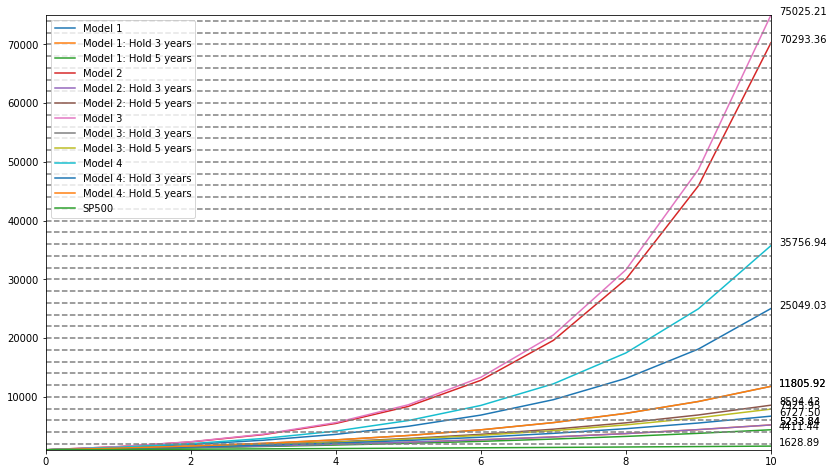

In [109]:
# plot the graph
plt.figure(figsize=(13,8))
plt.plot(graph_df.index, graph_df["Model 1"], label="Model 1")
plt.plot(graph_df.index, graph_df["Model 1: Hold 3 years"], label="Model 1: Hold 3 years")
plt.plot(graph_df.index, graph_df["Model 1: Hold 5 years"], label="Model 1: Hold 5 years")
plt.plot(graph_df.index, graph_df["Model 2"], label="Model 2")
plt.plot(graph_df.index, graph_df["Model 2: Hold 3 years"], label="Model 2: Hold 3 years")
plt.plot(graph_df.index, graph_df["Model 2: Hold 5 years"], label="Model 2: Hold 5 years")
plt.plot(graph_df.index, graph_df["Model 3"], label="Model 3")
plt.plot(graph_df.index, graph_df["Model 3: Hold 3 years"], label="Model 3: Hold 3 years")
plt.plot(graph_df.index, graph_df["Model 3: Hold 5 years"], label="Model 3: Hold 5 years")
plt.plot(graph_df.index, graph_df["Model 4"], label="Model 4")
plt.plot(graph_df.index, graph_df["Model 4: Hold 3 years"], label="Model 4: Hold 3 years")
plt.plot(graph_df.index, graph_df["Model 4: Hold 5 years"], label="Model 4: Hold 5 years")
plt.plot(graph_df.index, graph_df["SP500"], label="SP500")
plt.legend()
# y axis log
# plt.yscale("log")
# horizontal lines
for value in range(0,int(graph_df.iloc[-1,:].max()),2000):
    plt.axhline(y=value, color="gray", linestyle="--")

for var in (graph_df["Model 1"], graph_df["Model 1: Hold 3 years"], graph_df["Model 1: Hold 5 years"], graph_df["Model 2"], graph_df["Model 2: Hold 3 years"], graph_df["Model 2: Hold 5 years"], graph_df["Model 3"], graph_df["Model 3: Hold 3 years"], graph_df["Model 3: Hold 5 years"], graph_df["Model 4"], graph_df["Model 4: Hold 3 years"], graph_df["Model 4: Hold 5 years"], graph_df["SP500"]):
    plt.annotate('%0.2f' % var.max(), xy=(1, var.max()), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
# end plot at year 20
plt.xlim(0,10)
plt.ylim(1000,int(graph_df.iloc[-1,:].max()))
plt.show()

# Backtesting SHORT

In [110]:
# Solo nos interesan las columans numéricas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = basic_data.select_dtypes(include=numerics)

# Quitamos otras columnas que no nos interesan
numeric_df.drop(["Market Cap","CAGR","CAGR with divs","NR - Percentage Missing", "NR - Percentage Missing (Only Core)", "R - Percentage Missing (Only Core)", "R - Percentage Missing","R - Percentage Missing (Trivial Fix)", "R - Percentage Missing (Only Core) (Trivial Fix)"], axis=1, inplace=True)

In [111]:
# Model 1 -> CAGR : Usamos como entrenamiento las medias de todas las empresas (pero no las medias de las empresas en test)
# Model 1: Hold 3 Years -> CAGR Hold 3 Years : Usamos como entrenamiento las medias de todas las empresas pero no rebalanceamos el portfolio hasta dentro de 3 años
# Model 1: Hold 5 Years -> CAGR Hold 5 Years : Usamos como entrenamiento las medias de todas las empresas pero no rebalanceamos el portfolio hasta dentro de 5 años
# Model 2 -> CAGR Progressive : Usamos para predecir cada año un dataset con la media de los años anteriores 
# Model 2: Hold 3 Years -> CAGR Hold 3 Years : Usamos para predecir cada año un dataset con la media de los años anteriores pero no rebalanceamos el portfolio hasta dentro de 3 años
# Model 2: Hold 5 Years -> CAGR Hold 5 Years : Usamos para predecir cada año un dataset con la media de los años anteriores pero no rebalanceamos el portfolio hasta dentro de 5 años
# Model 3 -> CAGR Future : Usamos como entrenamiento las medias de todas las empresas, pero el target es el precio futuro (pero no las medias de las empresas en test)
# Model 3: Hold 3 Years -> CAGR Hold 3 Years : Usamos como entrenamiento las medias de todas las empresas pero no rebalanceamos el portfolio hasta dentro de 3 años
# Model 3: Hold 5 Years -> CAGR Hold 5 Years : Usamos como entrenamiento las medias de todas las empresas pero no rebalanceamos el portfolio hasta dentro de 5 años
# Model 4 -> CAGR Progressive : Usamos para predecir cada año un dataset con la media de los años anteriores, pero el target es el precio futuro
# Model 4: Hold 3 Years -> CAGR Hold 3 Years : Usamos para predecir cada año un dataset con la media de los años anteriores pero no rebalanceamos el portfolio hasta dentro de 3 años
# Model 4: Hold 5 Years -> CAGR Hold 5 Years : Usamos para predecir cada año un dataset con la media de los años anteriores pero no rebalanceamos el portfolio hasta dentro de 5 años

number_range = range(1,31,5)

results_df_2 = pd.DataFrame(index=number_range,columns=["Model 1","Model 1: Hold 3 Years","Model 1: Hold 5 Years","Model 2","Model 2: Hold 3 Years", "Model 2: Hold 5 Years", "Model 3","Model 3: Hold 3 Years","Model 3: Hold 5 Years", "Model 4", "Model 4: Hold 3 Years","Model 4: Hold 5 Years"])
results_df_2.index.name = "Numbers of stocks"
# Add df title
results_df_2.columns.name = "Model Short"

for n in number_range:
    cagr_list = []
    cagr_hold_3_list = []
    cagr_hold_5_list = []
    cagr_progressive_list = []
    cagr_progressive_hold_3_list = []
    cagr_progressive_hold_5_list = []
    cagr_future_list = []
    cagr_future_hold_3_list = []
    cagr_future_hold_5_list = []
    cagr_future_progressive_list = []
    cagr_future_progressive_hold_3_list = []
    cagr_future_progressive_hold_5_list = []
    for i in range(3):
        cagr, cagr_sp500, *rest = backtest(n, mode=0, sp500=True, get_worst=True)
        cagr_hold_3, *rest = backtest(n, mode=0, years_to_hold=3, get_worst=True)
        cagr_hold_5, *rest = backtest(n, mode=0, years_to_hold=5, get_worst=True)
        cagr_progressive, *rest = backtest(n, mode=2, get_worst=True)
        cagr_progressive_hold_3, *rest = backtest(n, mode=2, years_to_hold=3, get_worst=True)
        cagr_progressive_hold_5, *rest = backtest(n, mode=2, years_to_hold=5, get_worst=True)
        cagr_future, *rest = backtest(n, mode=-1, get_worst=True)
        cagr_future_hold_3, *rest = backtest(n, mode=-1, years_to_hold=3, get_worst=True)
        cagr_future_hold_5, *rest = backtest(n, mode=-1, years_to_hold=5, get_worst=True)
        cagr_future_progressive, *rest = backtest(n, mode=1, get_worst=True)
        cagr_future_progressive_hold_3, *rest = backtest(n, mode=1, years_to_hold=3, get_worst=True)
        cagr_future_progressive_hold_5, *rest = backtest(n, mode=1, years_to_hold=5, get_worst=True)

        cagr_list.append(cagr)
        cagr_hold_3_list.append(cagr_hold_3)
        cagr_hold_5_list.append(cagr_hold_5)
        cagr_progressive_list.append(cagr_progressive)
        cagr_progressive_hold_3_list.append(cagr_progressive_hold_3)
        cagr_progressive_hold_5_list.append(cagr_progressive_hold_5)
        cagr_future_list.append(cagr_future)
        cagr_future_hold_3_list.append(cagr_future_hold_3)
        cagr_future_hold_5_list.append(cagr_future_hold_5)
        cagr_future_progressive_list.append(cagr_future_progressive)
        cagr_future_progressive_hold_3_list.append(cagr_future_progressive_hold_3)
        cagr_future_progressive_hold_5_list.append(cagr_future_progressive_hold_5)
        
    results_df_2.loc[n, "Model 1"] = round(np.mean(cagr_list),2)
    results_df_2.loc[n, "Model 1: Hold 3 Years"] = round(np.mean(cagr_hold_3_list),2)
    results_df_2.loc[n, "Model 1: Hold 5 Years"] = round(np.mean(cagr_hold_5_list),2)
    results_df_2.loc[n, "Model 2"] = round(np.mean(cagr_progressive_list),2)
    results_df_2.loc[n, "Model 2: Hold 3 Years"] = round(np.mean(cagr_progressive_hold_3_list),2)
    results_df_2.loc[n, "Model 2: Hold 5 Years"] = round(np.mean(cagr_progressive_hold_5_list),2)
    results_df_2.loc[n, "Model 3"] = round(np.mean(cagr_future_list),2)
    results_df_2.loc[n, "Model 3: Hold 3 Years"] = round(np.mean(cagr_future_hold_3_list),2)
    results_df_2.loc[n, "Model 3: Hold 5 Years"] = round(np.mean(cagr_future_hold_5_list),2)
    results_df_2.loc[n, "Model 4"] = round(np.mean(cagr_future_progressive_list),2)
    results_df_2.loc[n, "Model 4: Hold 3 Years"] = round(np.mean(cagr_future_progressive_hold_3_list),2)
    results_df_2.loc[n, "Model 4: Hold 5 Years"] = round(np.mean(cagr_future_progressive_hold_5_list),2)


In [112]:
results_df_2 = results_df_2.T

In [113]:
results_df_2["Mean"] = results_df_2.mean(axis=1).round(2)
results_df_2["Std"] = results_df_2.std(axis=1).round(2)
results_df_2["Sharpe"] = results_df_2["Mean"]/results_df_2["Std"]
results_df_2["Sharpe"] = results_df_2["Sharpe"].round(2)
results_df_2

Numbers of stocks,1,6,11,16,21,26,Mean,Std,Sharpe
Model Short,,,,,,,,,
Model 1,0.14,0.11,0.12,0.08,0.08,0.06,0.10,0.03,3.33
Model 1: Hold 3 Years,-0.0,0.09,0.06,0.08,0.04,0.09,0.06,0.03,2.00
Model 1: Hold 5 Years,0.08,0.04,0.04,0.07,0.05,0.05,0.06,0.02,3.00
Model 2,-0.01,0.09,0.06,0.13,0.1,0.08,0.08,0.04,2.00
Model 2: Hold 3 Years,0.03,0.04,0.09,0.08,0.1,0.1,0.07,0.03,2.33
Model 2: Hold 5 Years,0.03,0.11,0.05,0.11,0.09,0.09,0.08,0.03,2.67
Model 3,0.05,0.03,0.07,0.09,0.08,0.06,0.06,0.02,3.00
Model 3: Hold 3 Years,-0.08,0.05,0.07,0.05,0.08,0.08,0.04,0.06,0.67
Model 3: Hold 5 Years,0.06,0.03,0.01,0.03,0.04,0.06,0.04,0.02,2.00


In [114]:
results_df_2["Mean 1"] = results_df_2.iloc[:,0:3].mean(axis=1).round(2)
results_df_2["Std 1"] = results_df_2.iloc[:,0:3].std(axis=1).round(2)
results_df_2["Mean 2"] = results_df_2.iloc[:,3:6].mean(axis=1).round(2)
results_df_2["Std 2"] = results_df_2.iloc[:,3:6].std(axis=1).round(2)
results_df_2["Sharpe 1"] = results_df_2["Mean 1"]/results_df_2["Std 1"]
results_df_2["Sharpe 2"] = results_df_2["Mean 2"]/results_df_2["Std 2"]
results_df_2["Sharpe 1"] = results_df_2["Sharpe 1"].round(2)
results_df_2["Sharpe 2"] = results_df_2["Sharpe 2"].round(2)



In [115]:
results_df_2.iloc[:,-6:]

Numbers of stocks,Mean 1,Std 1,Mean 2,Std 2,Sharpe 1,Sharpe 2
Model Short,,,,,,
Model 1,0.12,0.02,0.07,0.01,6.00,7.00
Model 1: Hold 3 Years,0.05,0.05,0.07,0.03,1.00,2.33
Model 1: Hold 5 Years,0.05,0.02,0.06,0.01,2.50,6.00
Model 2,0.05,0.05,0.10,0.03,1.00,3.33
Model 2: Hold 3 Years,0.05,0.03,0.09,0.01,1.67,9.00
Model 2: Hold 5 Years,0.06,0.04,0.10,0.01,1.50,10.00
Model 3,0.05,0.02,0.08,0.02,2.50,4.00
Model 3: Hold 3 Years,0.01,0.08,0.07,0.02,0.12,3.50
Model 3: Hold 5 Years,0.03,0.03,0.04,0.02,1.00,2.00


In [116]:
results_df_2 = results_df_2.T

In [117]:
graph_years = range(0,10)
graph_initial_value = 1000
model1_cagr = results_df_2.loc["Mean", "Model 1"]
model1_hold_3_cagr = results_df_2.loc["Mean", "Model 1: Hold 3 Years"]
model1_hold_5_cagr = results_df_2.loc["Mean", "Model 1: Hold 5 Years"]
model2_cagr = results_df_2.loc["Mean", "Model 2"]
model2_hold_3_cagr = results_df_2.loc["Mean", "Model 2: Hold 3 Years"]
model2_hold_5_cagr = results_df_2.loc["Mean", "Model 2: Hold 5 Years"]
model3_cagr = results_df_2.loc["Mean", "Model 3"]
model3_hold_3_cagr = results_df_2.loc["Mean", "Model 3: Hold 3 Years"]
model3_hold_5_cagr = results_df_2.loc["Mean", "Model 3: Hold 5 Years"]
model4_cagr = results_df_2.loc["Mean", "Model 4"]
model4_hold_3_cagr = results_df_2.loc["Mean", "Model 4: Hold 3 Years"]
model4_hold_5_cagr = results_df_2.loc["Mean", "Model 4: Hold 5 Years"]
sp500_graph_cagr = 0.05

graph_df = pd.DataFrame(index=graph_years, columns=["Model 1","Model 1: Hold 3 years","Model 1: Hold 5 years", "Model 2","Model 2: Hold 3 years","Model 2: Hold 5 years", "Model 3","Model 3: Hold 3 years","Model 3: Hold 5 years", "Model 4","Model 4: Hold 3 years","Model 4: Hold 5 years", "SP500"])
graph_df.iloc[0,:] = graph_initial_value

for year in range(1,11):
    graph_df.loc[year,"Model 1"] = graph_df.loc[year-1,"Model 1"] + (graph_df.loc[year-1,"Model 1"] * model1_cagr)
    graph_df.loc[year,"Model 1: Hold 3 years"] = graph_df.loc[year-1,"Model 1: Hold 3 years"] + (graph_df.loc[year-1,"Model 1: Hold 3 years"] * model1_hold_3_cagr)
    graph_df.loc[year,"Model 1: Hold 5 years"] = graph_df.loc[year-1,"Model 1: Hold 5 years"] + (graph_df.loc[year-1,"Model 1: Hold 5 years"] * model1_hold_5_cagr)
    graph_df.loc[year,"Model 2"] = graph_df.loc[year-1,"Model 2"] + (graph_df.loc[year-1,"Model 2"] * model2_cagr)
    graph_df.loc[year,"Model 2: Hold 3 years"] = graph_df.loc[year-1,"Model 2: Hold 3 years"] + (graph_df.loc[year-1,"Model 2: Hold 3 years"] * model2_hold_3_cagr)
    graph_df.loc[year,"Model 2: Hold 5 years"] = graph_df.loc[year-1,"Model 2: Hold 5 years"] + (graph_df.loc[year-1,"Model 2: Hold 5 years"] * model2_hold_5_cagr)
    graph_df.loc[year,"Model 3"] = graph_df.loc[year-1,"Model 3"] + (graph_df.loc[year-1,"Model 3"] * model3_cagr)
    graph_df.loc[year,"Model 3: Hold 3 years"] = graph_df.loc[year-1,"Model 3: Hold 3 years"] + (graph_df.loc[year-1,"Model 3: Hold 3 years"] * model3_hold_3_cagr)
    graph_df.loc[year,"Model 3: Hold 5 years"] = graph_df.loc[year-1,"Model 3: Hold 5 years"] + (graph_df.loc[year-1,"Model 3: Hold 5 years"] * model3_hold_5_cagr)
    graph_df.loc[year,"Model 4"] = graph_df.loc[year-1,"Model 4"] + (graph_df.loc[year-1,"Model 4"] * model4_cagr)
    graph_df.loc[year,"Model 4: Hold 3 years"] = graph_df.loc[year-1,"Model 4: Hold 3 years"] + (graph_df.loc[year-1,"Model 4: Hold 3 years"] * model4_hold_3_cagr)
    graph_df.loc[year,"Model 4: Hold 5 years"] = graph_df.loc[year-1,"Model 4: Hold 5 years"] + (graph_df.loc[year-1,"Model 4: Hold 5 years"] * model4_hold_5_cagr)
    graph_df.loc[year,"SP500"] = graph_df.loc[year-1,"SP500"] + (graph_df.loc[year-1,"SP500"] * sp500_graph_cagr)


In [118]:
graph_df

,Model 1,Model 1: Hold 3 years,Model 1: Hold 5 years,Model 2,Model 2: Hold 3 years,Model 2: Hold 5 years,Model 3,Model 3: Hold 3 years,Model 3: Hold 5 years,Model 4,Model 4: Hold 3 years,Model 4: Hold 5 years,SP500
0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
1,1100.0,1060.0,1060.0,1080.0,1070.0,1080.0,1060.0,1040.0,1040.0,1030.0,1020.0,1010.0,1050.0
2,1210.0,1123.6,1123.6,1166.4,1144.9,1166.4,1123.6,1081.6,1081.6,1060.9,1040.4,1020.1,1102.5
3,1331.0,1191.016,1191.016,1259.712,1225.043,1259.712,1191.016,1124.864,1124.864,1092.727,1061.208,1030.301,1157.625
4,1464.1,1262.47696,1262.47696,1360.48896,1310.79601,1360.48896,1262.47696,1169.85856,1169.85856,1125.50881,1082.43216,1040.60401,1215.50625
5,1610.51,1338.225578,1338.225578,1469.328077,1402.551731,1469.328077,1338.225578,1216.652902,1216.652902,1159.274074,1104.080803,1051.01005,1276.281562
6,1771.561,1418.519112,1418.519112,1586.874323,1500.730352,1586.874323,1418.519112,1265.319018,1265.319018,1194.052297,1126.162419,1061.520151,1340.095641
7,1948.7171,1503.630259,1503.630259,1713.824269,1605.781476,1713.824269,1503.630259,1315.931779,1315.931779,1229.873865,1148.685668,1072.135352,1407.100423
8,2143.58881,1593.848075,1593.848075,1850.93021,1718.18618,1850.93021,1593.848075,1368.56905,1368.56905,1266.770081,1171.659381,1082.856706,1477.455444
9,2357.947691,1689.478959,1689.478959,1999.004627,1838.459212,1999.004627,1689.478959,1423.311812,1423.311812,1304.773184,1195.092569,1093.685273,1551.328216


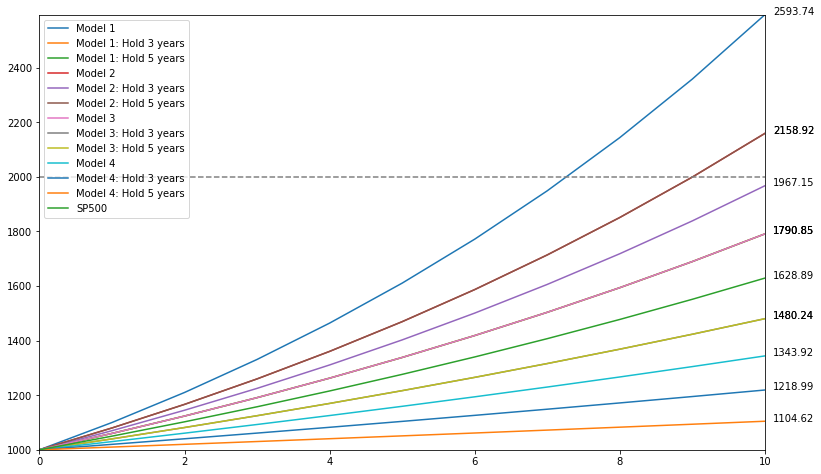

In [119]:
# plot the graph
plt.figure(figsize=(13,8))
plt.plot(graph_df.index, graph_df["Model 1"], label="Model 1")
plt.plot(graph_df.index, graph_df["Model 1: Hold 3 years"], label="Model 1: Hold 3 years")
plt.plot(graph_df.index, graph_df["Model 1: Hold 5 years"], label="Model 1: Hold 5 years")
plt.plot(graph_df.index, graph_df["Model 2"], label="Model 2")
plt.plot(graph_df.index, graph_df["Model 2: Hold 3 years"], label="Model 2: Hold 3 years")
plt.plot(graph_df.index, graph_df["Model 2: Hold 5 years"], label="Model 2: Hold 5 years")
plt.plot(graph_df.index, graph_df["Model 3"], label="Model 3")
plt.plot(graph_df.index, graph_df["Model 3: Hold 3 years"], label="Model 3: Hold 3 years")
plt.plot(graph_df.index, graph_df["Model 3: Hold 5 years"], label="Model 3: Hold 5 years")
plt.plot(graph_df.index, graph_df["Model 4"], label="Model 4")
plt.plot(graph_df.index, graph_df["Model 4: Hold 3 years"], label="Model 4: Hold 3 years")
plt.plot(graph_df.index, graph_df["Model 4: Hold 5 years"], label="Model 4: Hold 5 years")
plt.plot(graph_df.index, graph_df["SP500"], label="SP500")
plt.legend()
# y axis log
# plt.yscale("log")
# horizontal lines
for value in range(0,int(graph_df.iloc[-1,:].max()),2000):
    plt.axhline(y=value, color="gray", linestyle="--")

for var in (graph_df["Model 1"], graph_df["Model 1: Hold 3 years"], graph_df["Model 1: Hold 5 years"], graph_df["Model 2"], graph_df["Model 2: Hold 3 years"], graph_df["Model 2: Hold 5 years"], graph_df["Model 3"], graph_df["Model 3: Hold 3 years"], graph_df["Model 3: Hold 5 years"], graph_df["Model 4"], graph_df["Model 4: Hold 3 years"], graph_df["Model 4: Hold 5 years"], graph_df["SP500"]):
    plt.annotate('%0.2f' % var.max(), xy=(1, var.max()), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
# end plot at year 20
plt.xlim(0,10)
plt.ylim(1000,int(graph_df.iloc[-1,:].max()))
plt.show()

# Predicciones de este año

In [120]:
data = get_best_predictions_for_year(-1, [])

In [121]:
data.columns

Index(['IV Grahams Number', 'Goodwill', 'Deferred Income Tax',
       'IV Grahams Number 5', 'Intrinsic Value 5',
       'Income Before Tax growth year over year',
       'Gross Profit growth 5 year average', 'Operating Expenses',
       'Revenue growth 5 year average',
       'Capital Employed growth 5 year average', 'Debt to Equity',
       'Operating Income per share', 'Book value per share',
       'Intrinsic Value 3', 'Revenue growth year over year',
       'Short-Term Investments', 'Dividends Paid', 'Other Expenses',
       'Stock Based Compensation', 'Capital Employed growth year over year',
       'Year 2022 Close', 'Predicted 2022', 'Error 2022', 'Error % 2022'],
      dtype='object')

In [122]:
# data.sort_values(by=["Error % 2022"], ascending=False, inplace=True)
# data[["Year 2022 Close", "Predicted 2022","ROCE","Error % 2022"]].dropna(thresh=3)

KeyError: "['ROCE'] not in index"

# Probando los modelos

In [149]:
# Solo nos interesan las columans numéricas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = basic_data.select_dtypes(include=numerics)

# Quitamos otras columnas que no nos interesan
numeric_df.drop(["Market Cap","CAGR","CAGR with divs","NR - Percentage Missing", "NR - Percentage Missing (Only Core)", "R - Percentage Missing (Only Core)", "R - Percentage Missing","R - Percentage Missing (Trivial Fix)", "R - Percentage Missing (Only Core) (Trivial Fix)"], axis=1, inplace=True)

In [150]:
years = range(2001,2021)
model1_score = get_best_predictions_for_year(0, years, only_test=True)
model3_score = get_best_predictions_for_year(-1, years, only_test=True)

score_df = pd.DataFrame(index=["R_Square", "Negative MAE", "Negative RMSE"], columns=["Model 1","Model 3"])
score_df.at["R_Square", "Model 1"] = np.mean(model1_score.get("test_r2"))
score_df.at["Negative MAE", "Model 1"] = np.mean(model1_score.get("test_neg_mean_absolute_error"))
score_df.at["Negative RMSE", "Model 1"] = np.mean(model1_score.get("test_neg_root_mean_squared_error"))
score_df.at["R_Square", "Model 3"] = np.mean(model3_score.get("test_r2"))
score_df.at["Negative MAE", "Model 3"] = np.mean(model3_score.get("test_neg_mean_absolute_error"))
score_df.at["Negative RMSE", "Model 3"] = np.mean(model3_score.get("test_neg_root_mean_squared_error"))

score_df

dataset 0.csv not found


KeyboardInterrupt: 

In [146]:
scores_df = pd.DataFrame(index=years, columns=["Model 2: R_Square", "Model 4: R_Square", "Model 2: MAE","Model 4: MAE", "Model 2: RMSE", "Model 4: RMSE"])
model2_scores = get_dataset_by_year(years, future=False, only_test=True)
model4_scores = get_dataset_by_year(years, future=True, only_test=True)

for year in years:
    scores_df.at[year, "Model 2: R_Square"] = np.mean(model2_scores[year-2001].get("test_r2")).round(4)
    scores_df.at[year, "Model 4: R_Square"] = np.mean(model4_scores[year-2001].get("test_r2")).round(4)

    scores_df.at[year, "Model 2: MAE"] = np.mean(model2_scores[year-2001].get("test_neg_mean_absolute_error")).round(4)
    scores_df.at[year, "Model 4: MAE"] = np.mean(model4_scores[year-2001].get("test_neg_mean_absolute_error")).round(4)

    scores_df.at[year, "Model 2: RMSE"] = np.mean(model2_scores[year-2001].get("test_neg_root_mean_squared_error")).round(4)
    scores_df.at[year, "Model 4: RMSE"] = np.mean(model4_scores[year-2001].get("test_neg_root_mean_squared_error")).round(4)

scores_df

,Model 2: R_Square,Model 4: R_Square,Model 2: MAE,Model 4: MAE,Model 2: RMSE,Model 4: RMSE
2001,0.4624,0.3128,-17.3997,-19.2497,-122.3878,-171.7657
2002,0.522,0.2253,-14.2685,-15.8144,-126.0837,-145.1388
2003,0.3656,0.2838,-15.1918,-14.6605,-121.1287,-117.2076
2004,0.0897,-0.1444,-16.9818,-18.8571,-138.8929,-154.8195
2005,-29.4997,-167.5341,-36.4765,-51.3668,-406.7925,-671.9146
2006,-27.3597,-202.7278,-40.9826,-69.8706,-437.3113,-909.8598
2007,-28.4599,-57.3123,-45.0286,-58.7244,-631.4421,-826.8386
2008,-45.5613,-4.5425,-49.7055,-45.4373,-577.63,-468.3311
2009,-1.0832,-2.4791,-30.4791,-30.8091,-319.6485,-340.528
2010,-0.5125,-0.2971,-26.1915,-28.898,-254.4644,-271.8914


# Obtención de un portfolio

In [126]:
cagr_future_progressive, SP500, portfolio = backtest(6, mode=1)

In [127]:
portfolio[["Portfolio Tickers End", "Ganancia", "Cumulative Gain", "Ganancia %"]]

,Portfolio Tickers End,Ganancia,Cumulative Gain,Ganancia %
2001,"[DAR, GTN-A, BUKS, CMT, ASX, CTHR]",NaN,NaN,NaN
2002,"[BUKS, DAR, FC]",517.316322,517.316322,51.99
2003,"[CRWS, IRCP, DORM, CMT, EDUC, DAR]",1436.829997,1954.146319,143.80
2004,"[AUY, FC, ISRG, EVC, KOSS, JOUT]",243.695485,2197.841803,24.36
2005,"[ASX, DAR, DMRC, CP, CRWS, GNTX]",788.206478,2986.048282,78.66
2006,"[LCTX, EDUC, MA, ASX, ATVI, DSNY]",1049.011505,4035.059786,105.30
2007,"[MNDO, GPL, EDUC, MMLP, CTHR, HDSN]",434.277136,4469.336923,43.57
2008,"[MNDO, CTHR, INBP, GSAT, GTN-A, EVC]",-482.722218,3986.614705,-48.40
2009,"[MIC, INBP, MLSS, GPL, BUKS, GTN]",2394.556107,6381.170812,239.51
2010,"[MLSS, GTN, INBP, CTHR, CTSO, LTRX]",468.104382,6849.275194,46.81


# Análisis de los features

In [ ]:
# save features
# features.to_csv("features_params.csv")

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
You supplied gpu_hist = True
You supplied n_jobs = -1
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (2683, 1124)
    Loaded train data. Shape = (2683, 1124)
    Some column names had special characters which were removed...
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ##############

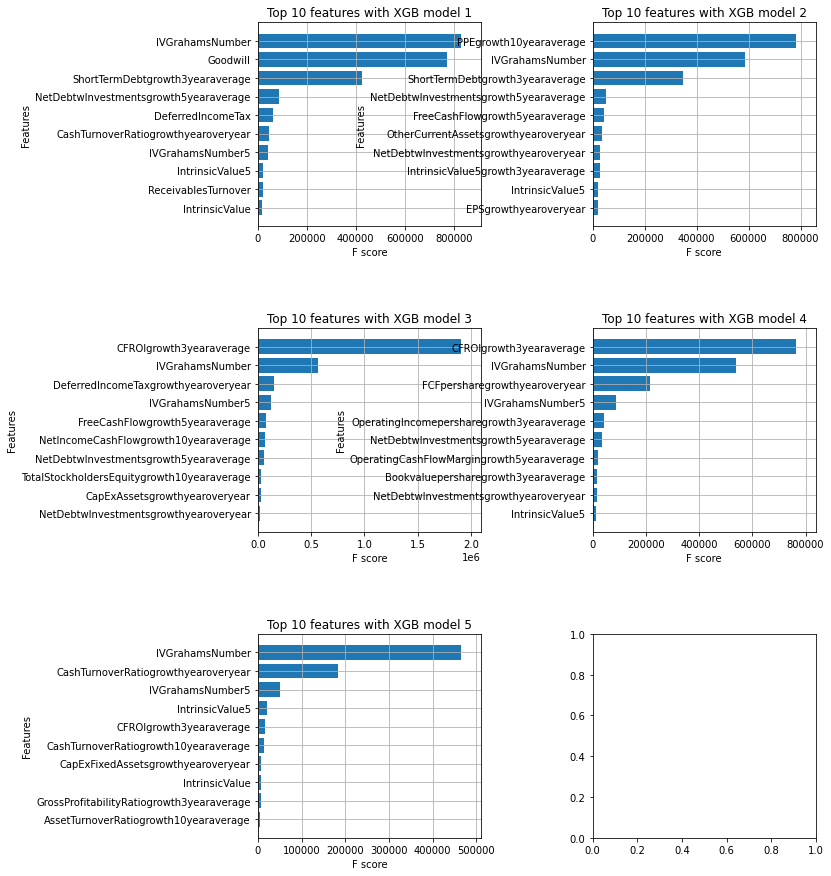

            Total time taken for XGBoost feature selection = 63 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 356 important features. Too many to print...

    Time taken for feature selection = 86 seconds
    Reverted column names to original names given in train dataset


In [165]:
X_clean, y = make_dataset_for_year(0,get_features=True, recalculate=False)

In [167]:
model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist")

grid_rf = {
'n_estimators': np.arange(100,1001,100), # 9 its
'learning_rate': np.arange(0.01,1,0.1), # 10 its
'max_depth': np.arange(1, 10, 1), # 10 its
'tree_method': ['gpu_hist'], # Total: 9 x 10 x 10 = 900
}

# optimización de parámetros
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf,scoring=('r2'),n_jobs=-1)
rscv_fit = rscv.fit(X_clean, y)
best_parameters = rscv_fit.best_params_
best_score = rscv_fit.best_score_
print(best_parameters)
print(best_score)

# {'n_estimators': 101, 'max_depth': 5, 'learning_rate': 0.1}

# {'n_estimators': 951, 'max_depth': 8, 'learning_rate': 0.30000000000000004}
# {'n_estimators': 901, 'max_depth': 10, 'learning_rate': 0.7000000000000001}

{'tree_method': 'gpu_hist', 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.41000000000000003}
0.7615219135652673


In [170]:
best_model = XGBRegressor(n_estimators=400, learning_rate=0.41000000000000003, n_jobs=-1, max_depth=6, tree_method="gpu_hist")

cv_results = cross_validate(best_model, X_clean, y, cv=5 ,  scoring=('r2'))
np.mean(cv_results.get("test_score"))

0.7615219135652673

In [141]:
primeros_20_features = X_clean.columns
# convert to df
primeros_20_features_df = pd.DataFrame(primeros_20_features)
primeros_20_features_df.to_csv("features_params.csv")

In [143]:
X_clean.columns

Index(['IV Grahams Number', 'Goodwill', 'Deferred Income Tax',
       'IV Grahams Number 5', 'Intrinsic Value 5',
       'Income Before Tax growth year over year',
       'Gross Profit growth 5 year average', 'Operating Expenses',
       'Revenue growth 5 year average',
       'Capital Employed growth 5 year average',
       ...
       'Return on Equity growth year over year', 'US Unemployment Rate',
       'Return on Equity growth 10 year average', 'IV Grahams Number 10',
       'Inflation Rate Euro Area', 'Equity Multiplier growth 3 year average',
       'Euro Area Unemployment Rate', 'PEG 3', 'PER_5', 'Grahams Number 10'],
      dtype='object', length=102)

In [ ]:
# show correlated features for every feature
corr = X_with_all_features.corr()
corr.style.background_gradient(cmap='coolwarm')
# only show the features that are correlated with X_clean (features)
corr_features = corr.loc[:, X_clean.columns]

In [75]:
def get_high_corr_features(corr_features, target_feature, threshold):
    return corr_features.loc[corr_features[target_feature] > threshold, target_feature]

In [82]:
get_high_corr_features(corr_features,"Gross Profit growth 5 year average", 0.8)

Gross Profit growth year over year     0.847971
Gross Profit growth 3 year average     0.962061
Gross Profit growth 5 year average     1.000000
Gross Profit growth 10 year average    0.991811
Name: Gross Profit growth 5 year average, dtype: float64

In [78]:
corr_features.columns

Index(['IV Grahams Number', 'Goodwill', 'Deferred Income Tax',
       'IV Grahams Number 5', 'Intrinsic Value 5',
       'Income Before Tax growth year over year',
       'Gross Profit growth 5 year average', 'Operating Expenses',
       'Revenue growth 5 year average',
       'Capital Employed growth 5 year average',
       ...
       'Return on Equity growth year over year', 'US Unemployment Rate',
       'Return on Equity growth 10 year average', 'IV Grahams Number 10',
       'Inflation Rate Euro Area', 'Equity Multiplier growth 3 year average',
       'Euro Area Unemployment Rate', 'PEG 3', 'PER_5', 'Grahams Number 10'],
      dtype='object', length=102)

In [39]:
best_model.fit(X_clean, y)
# preds = best_model.predict(X_clean)
# individual_data.values.reshape(-1, 142)
# preds

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.7000000000000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=901,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
# create dataframe with features of feature importance
feature_importance = pd.DataFrame(best_model.feature_importances_, index=X_clean.columns, columns=["Importance"])
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
feature_importance["Cum sum"] = feature_importance["Importance"].cumsum()



In [ ]:
feature_importance[feature_importance["Cum sum"] > 0.9]

,Importance,Cum sum
Intrinsic Value,4.014795e-01,0.963427
Cash and Cash Equivalents,1.296065e-02,0.976388
Operating Income per share growth 3 year average,9.399556e-03,0.985788
Intrinsic Value 5,4.565848e-03,0.990353
Intrinsic Value 3,1.721687e-03,0.992075
...,...,...
Invested Capital growth 10 year average,4.187109e-07,0.999999
Capital Employed growth 3 year average,4.065270e-07,0.999999
Cash Provided by Operating Activities,3.462791e-07,1.000000
US GDP,4.438906e-08,1.000000


In [31]:
calculate_valuation_metrics("AAPL")[["PER Last Year", "Intrinsic Value", "EPS", "Close"]]

,PER Last Year,Intrinsic Value,EPS,Close
1985,NaN,NaN,0.00,0.085
1986,inf,inf,0.01,0.150
1987,15.000000,0.150000,0.01,0.350
1988,35.000000,1.050000,0.03,0.370
1989,12.333333,0.370000,0.03,0.360
1990,12.000000,0.360000,0.03,0.340
1991,11.333333,0.226667,0.02,0.465
1992,23.250000,0.930000,0.04,0.515
1993,12.875000,0.128750,0.01,0.315
1994,31.500000,0.630000,0.02,0.300


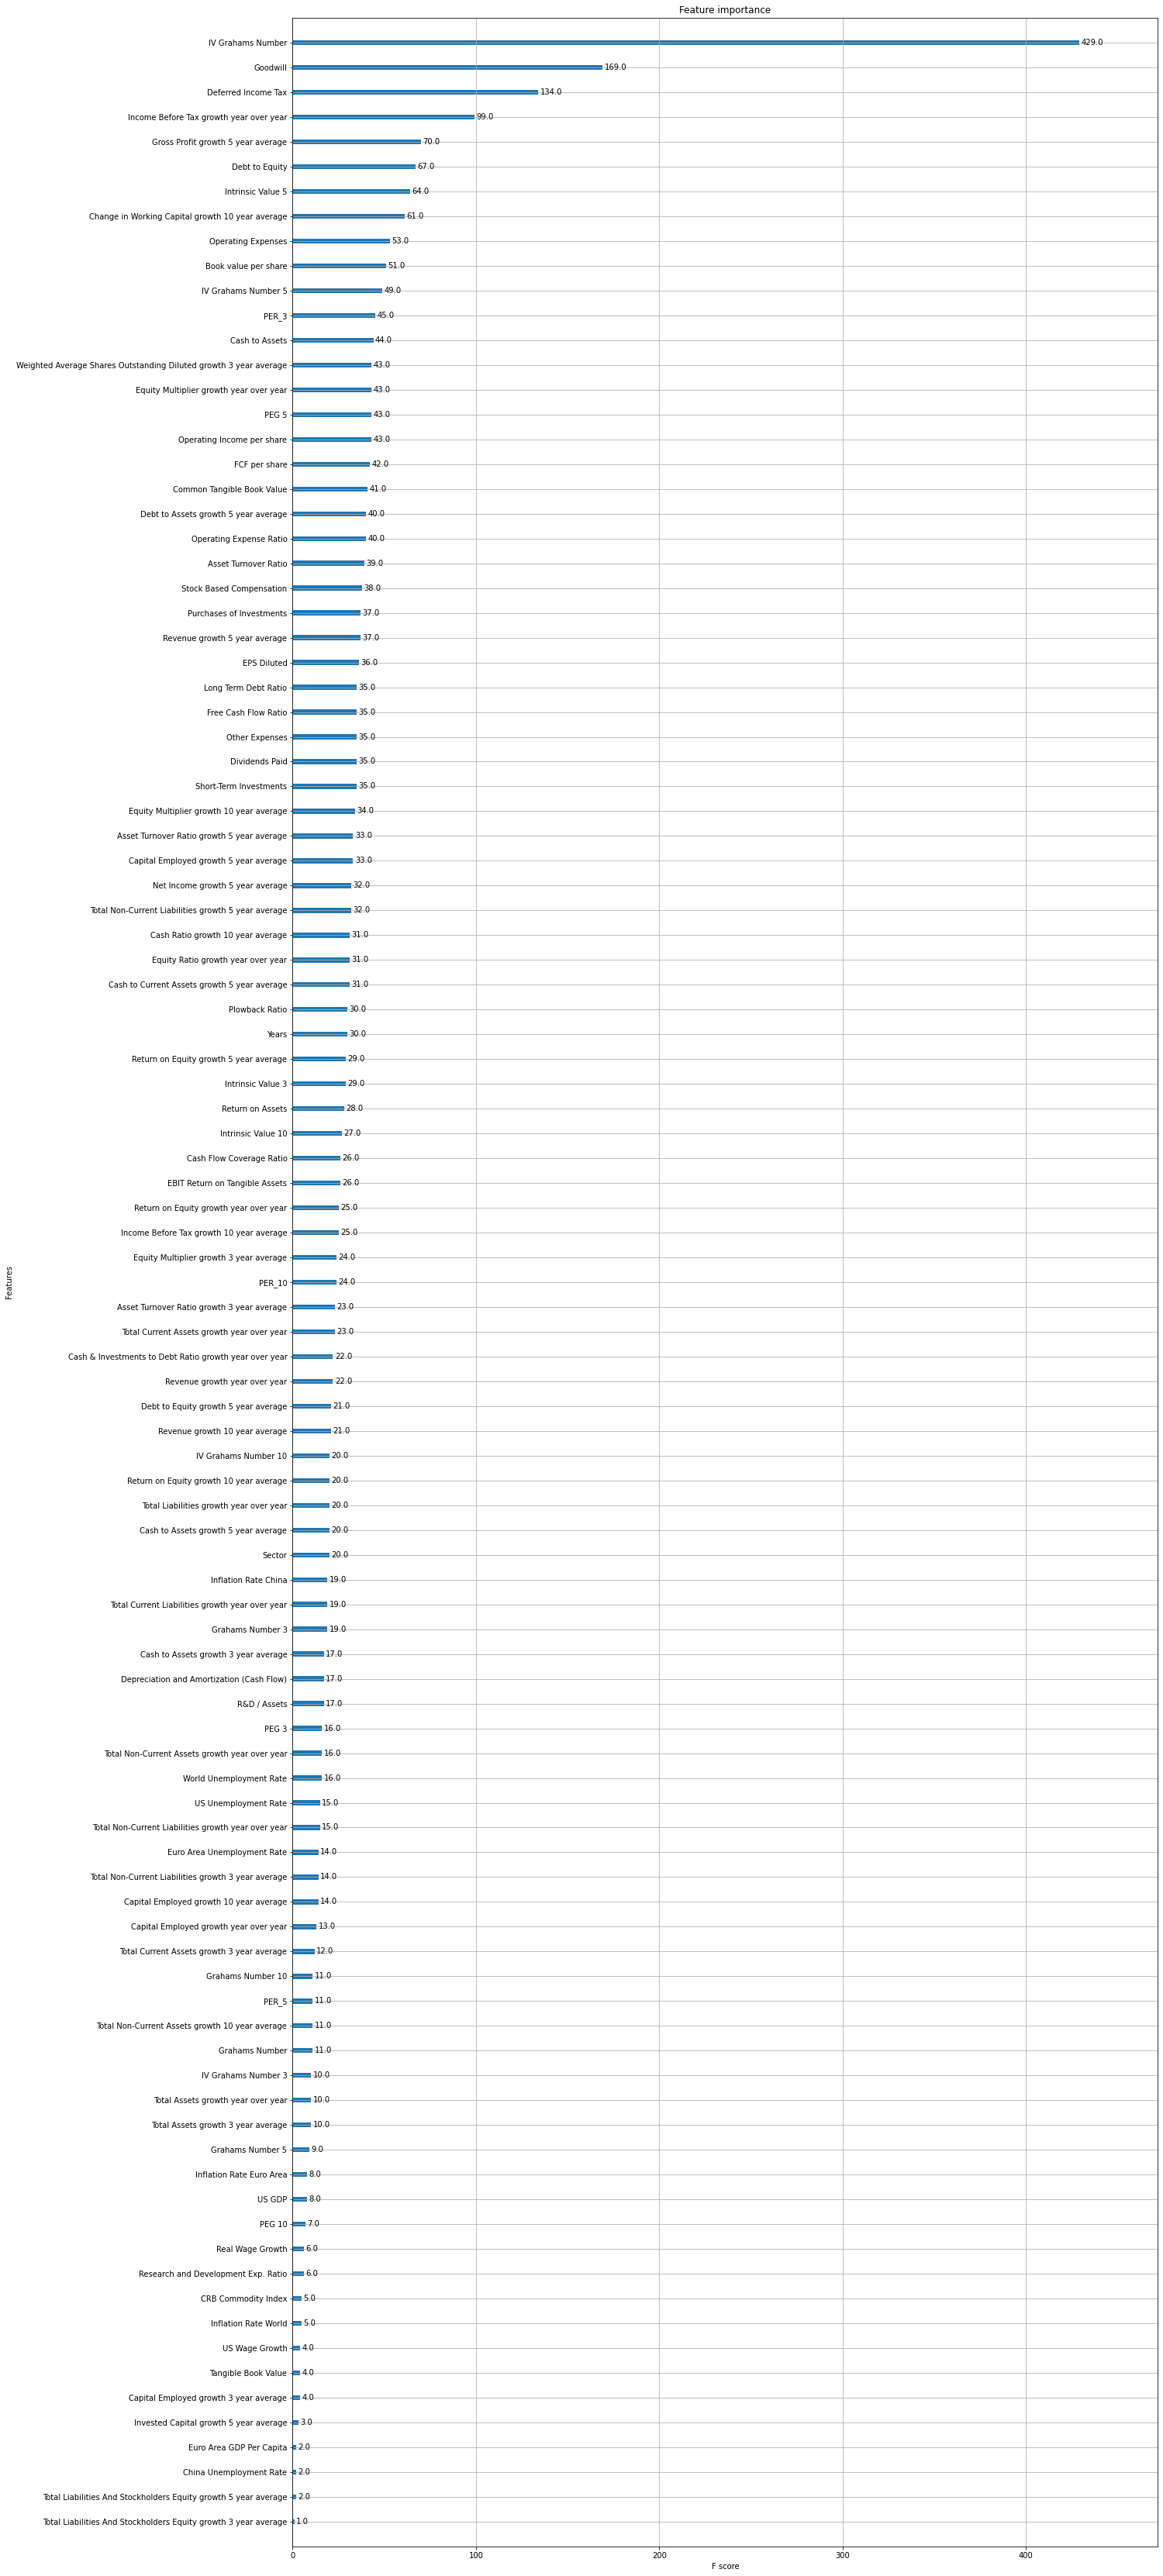

In [40]:
plt.rcParams['figure.figsize'] = (20, 60)
plot_importance(best_model)
plt.show()

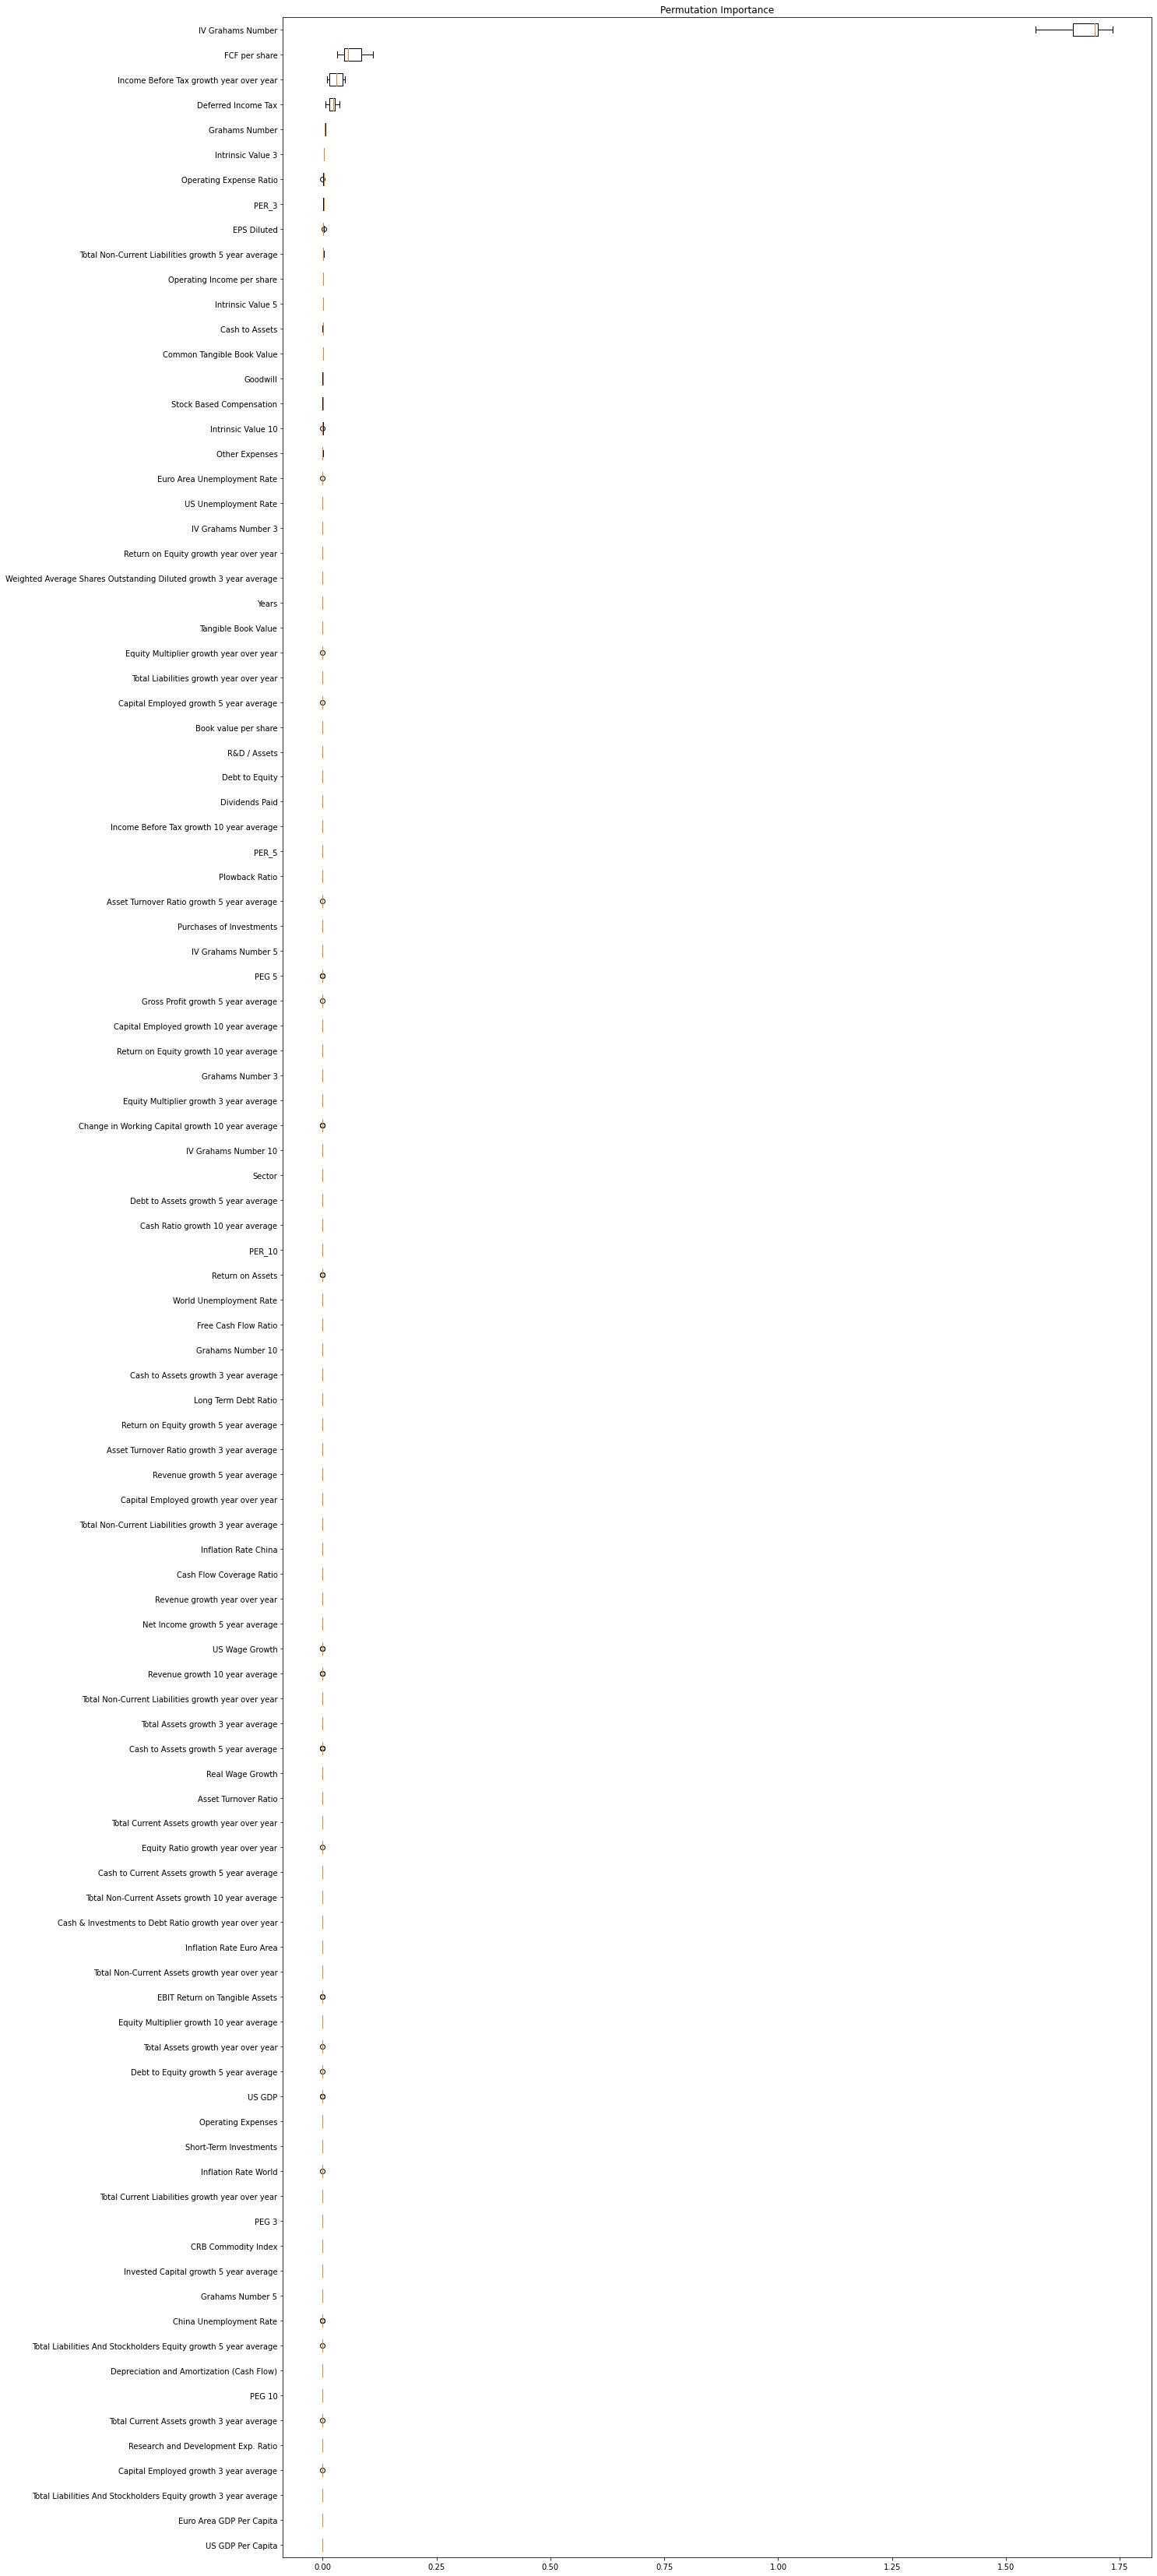

In [37]:
result = permutation_importance(best_model, X_clean, y,scoring=('r2'), n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

plt.rcParams['figure.figsize'] = (20, 60)
fig = plt.figure()
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(X_clean.columns)[sorted_idx])
plt.title("Permutation Importance")
plt.show()

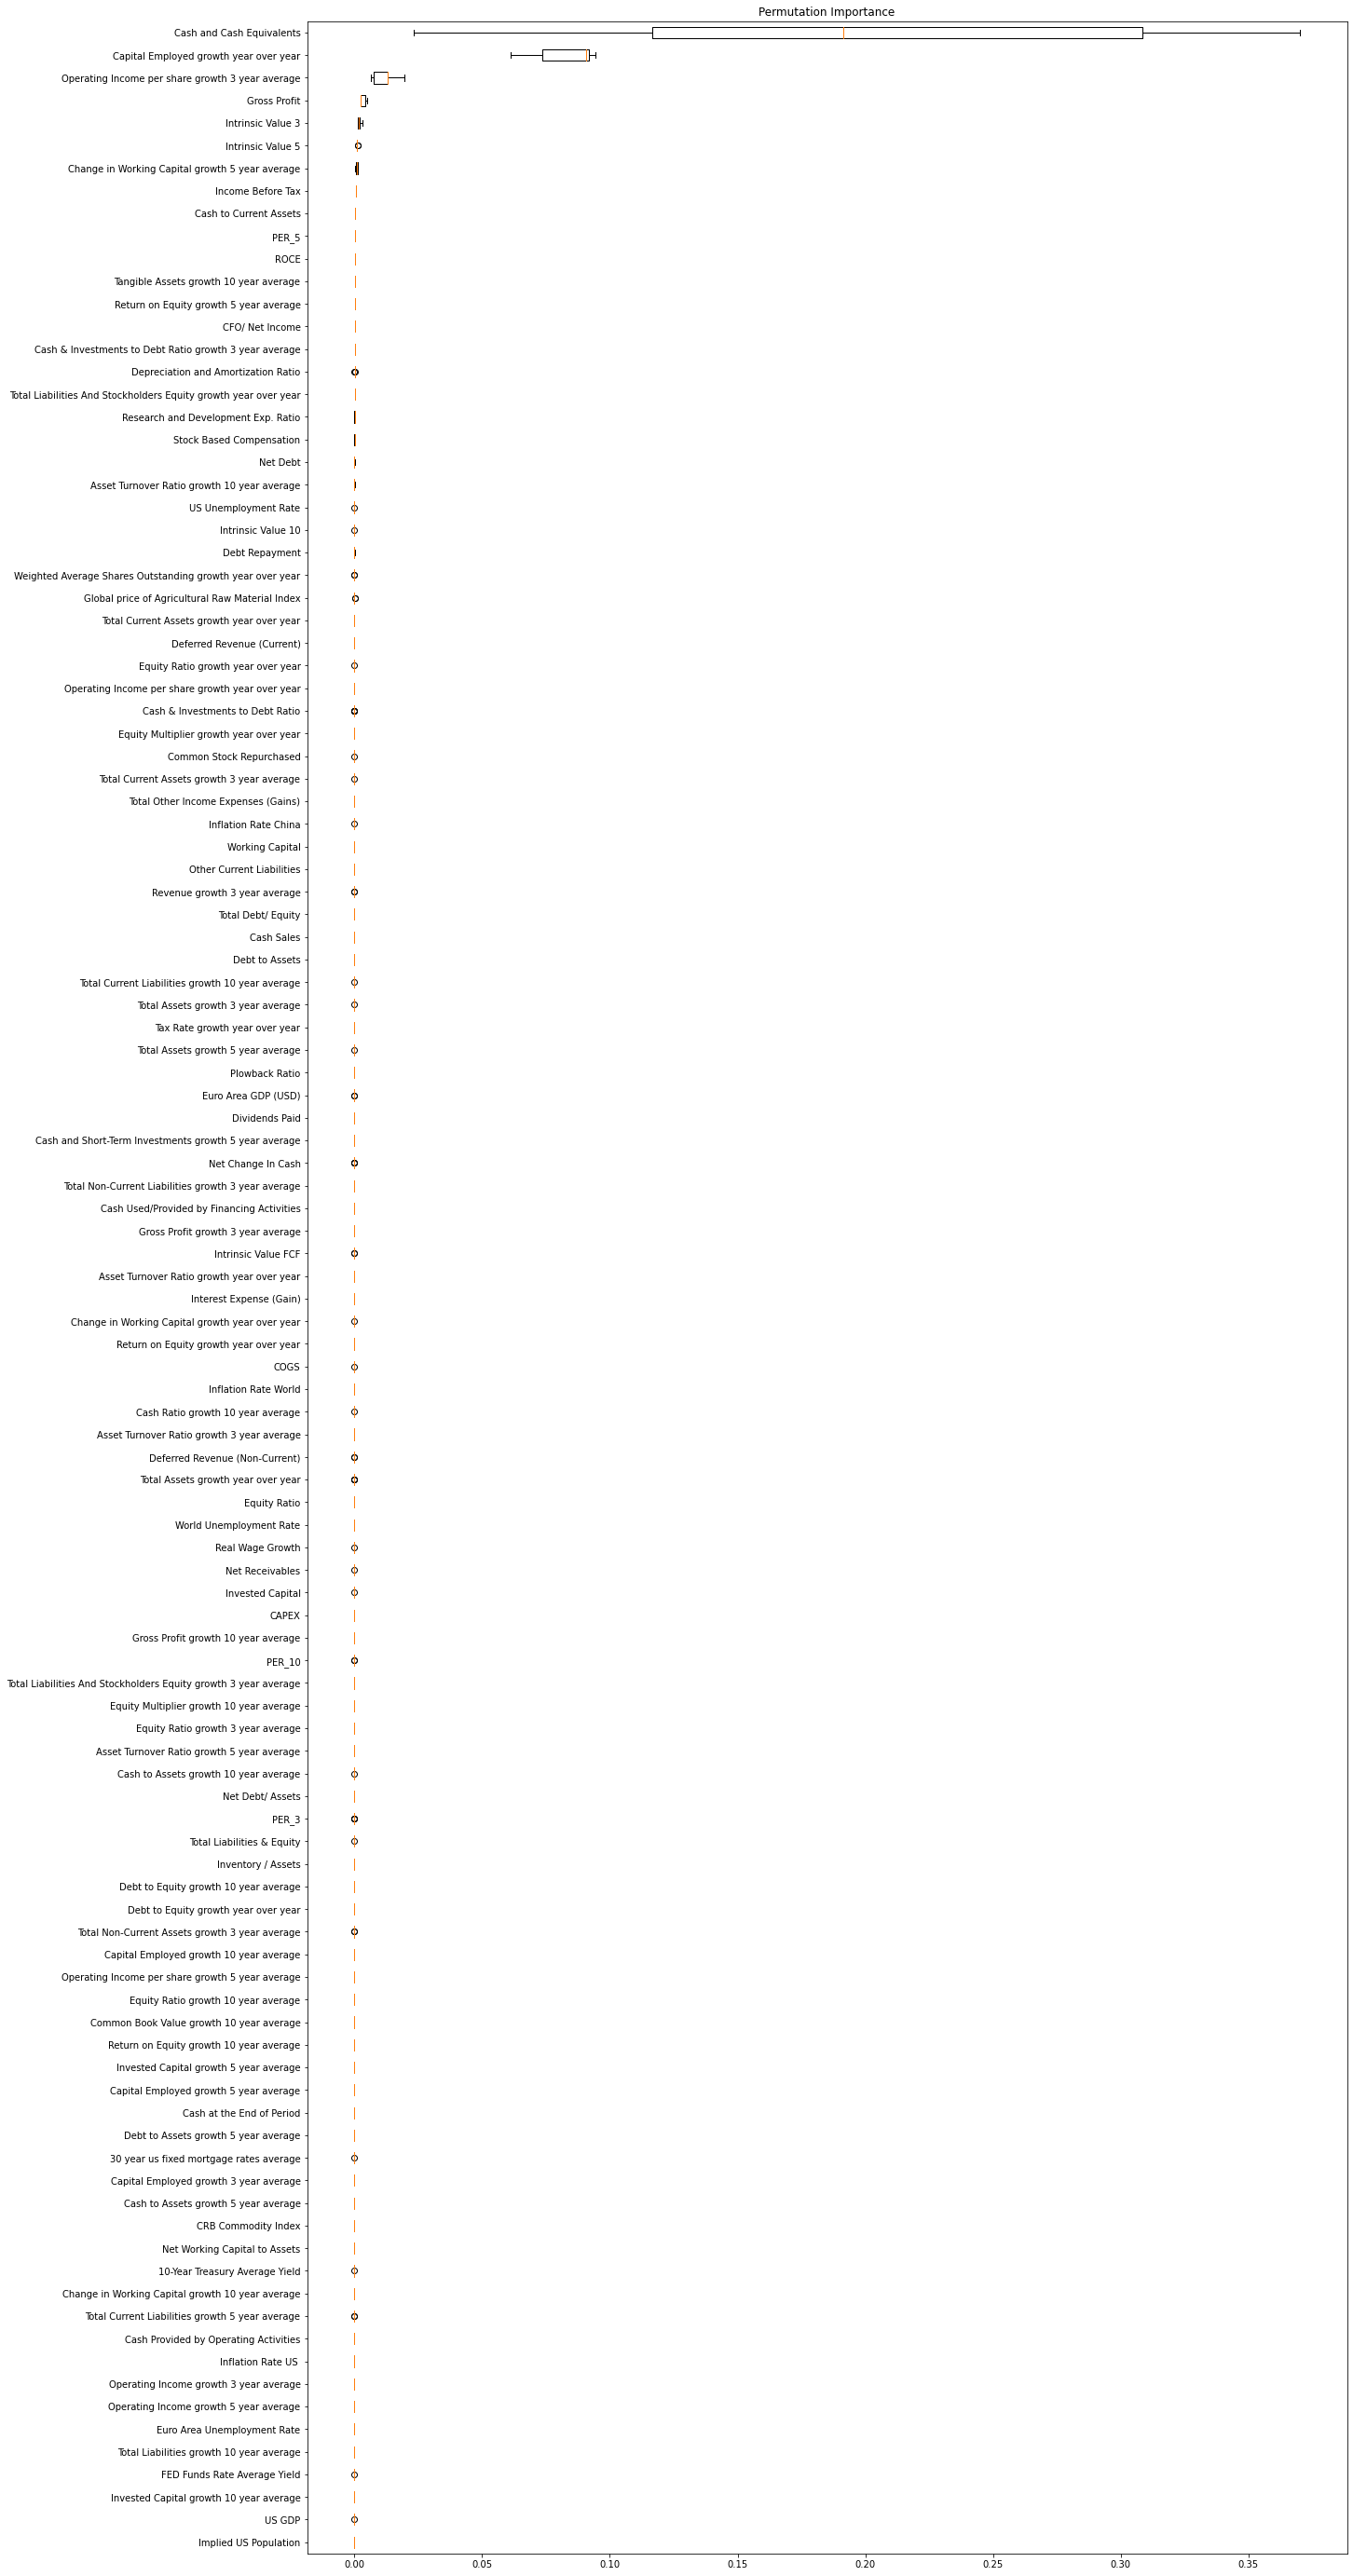

In [16]:
# Quitando la primera
plt.rcParams['figure.figsize'] = (20, 50)
fig = plt.figure()
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T[:,:-1], vert=False, labels=np.array(X_clean.columns)[sorted_idx][:-1])
plt.title("Permutation Importance")
plt.show()

# Comparación con el mercado


In [ ]:
X_clean["Preds"] = preds
X_clean["Close"] = y

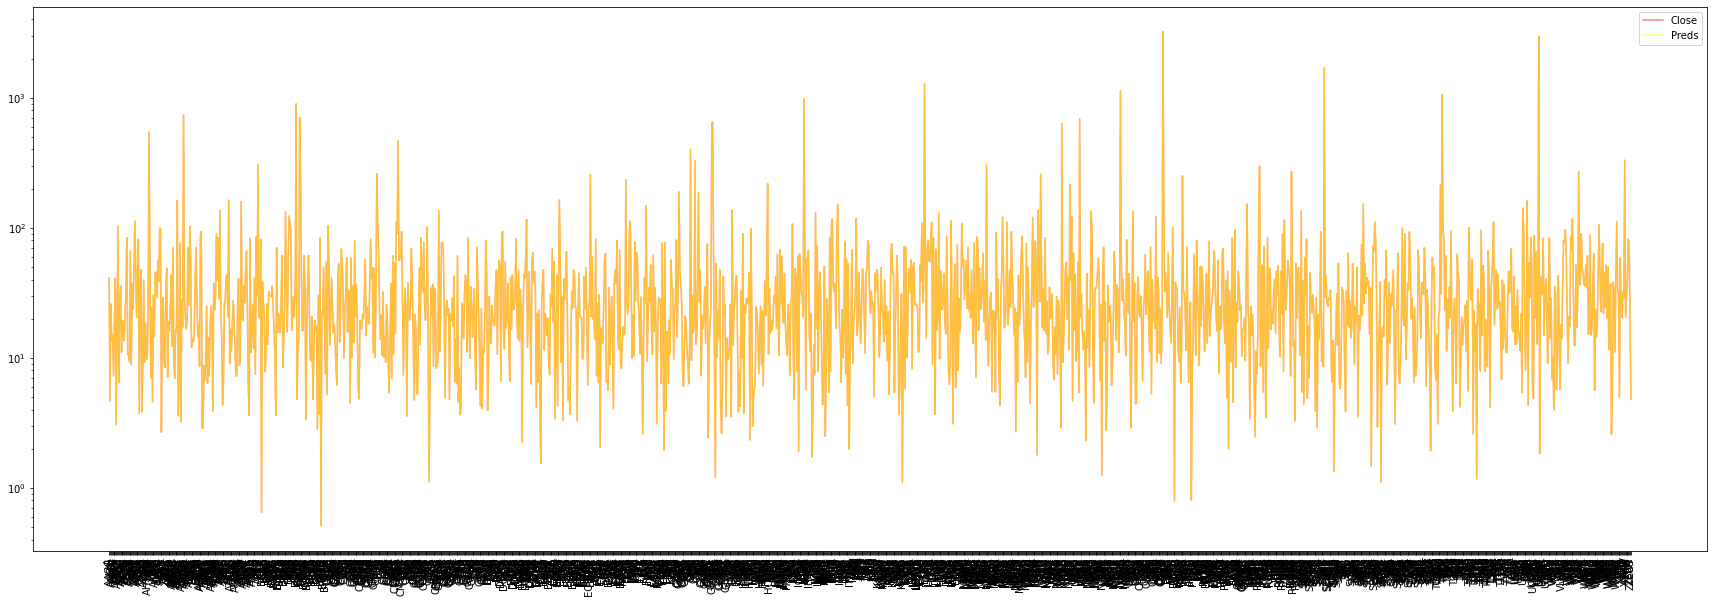

In [ ]:
plt.rcParams['figure.figsize'] = (30, 10)

plot_data = X_clean

# plot lineplot with close and preds on same axis
plt.plot(plot_data["Close"], label="Close", color="red", alpha=0.5)
plt.plot(plot_data["Preds"], label="Preds", color="yellow", alpha=0.5)
plt.xticks(rotation=90)
# log y axis
plt.yscale('log')
plt.legend()
plt.show()